# General approach 

### Initial imports of necessary modules

### Chapter 1: small amount of data

0. Find abbreviations (def find_abbreviations)

1. Convert abbreviations (def abbreviations_conversion)

2. Get rid of digits, emails, ip addresses (def remove_digits_emails_ips)

3. Lemmatize english and russiann words (def lemmatize_eng_rus_words)

4. Find low and hi frequency words (def frequency_analysis)

5. Apply stop words (nltk + low and hi frequency words) (def apply_stopwords_general)

6. Build the LDA monogram model. 

7. Do some optimizations with a) getting rid of some english words b) including only 95% percntile words

8. Build bigram and trigram models


### Chapter 2: full dataset

1. Prepare the dataset (Steps 1-6 in chapter 1)

2. Make biigram model

3. Check anomaly detection hipothesys


### Chapter 3: berttopics and DBSCAN as an alternative way to conduct the problem

------------------------------------------------------------------------------------------------------------

## Initial imports of necessary modules

In [2]:
#!pip install -U pip setuptools wheel
#!pip install -U spacy
#!python -m spacy download en_core_web_sm
#!python -m spacy download ru_core_news_sm
#import spacy
#!pip install pyLDAvis

In [3]:
import pandas as pd
import numpy as np
import pickle
import re
import string
from collections import defaultdict

In [4]:
#import spacy

In [5]:
#from sklearn.feature_extraction.text import CountVectorizer
#from sklearn.decomposition import LatentDirichletAllocation
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords as nltk_stopwords
import time
from gensim.test.utils import datapath
import datetime
from pprint import pprint
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import spacy
import pyLDAvis
import pyLDAvis.gensim  
import matplotlib.pyplot as plt
%matplotlib inline
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)
import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\slavochka\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Part 1: Small amount of data (test data)

In [6]:
# Lets load the small test dataset (around 10000 records)
df_test = pd.read_excel('test_1405.xlsx', sheet_name='Sheet1')

In [199]:
#df_test[10:12]

In [8]:
df_test['full_request'] = df_test['Тема ЗНО'] + ' ' + df_test['Информация']

In [9]:
df_test.isna().any()

ЗНО                 False
Категория           False
Услуга(объект)      False
Тема ЗНО            False
Информация          False
Дата регистрации    False
full_request        False
dtype: bool

In [10]:
df_test.shape

(10795, 7)

## 1. Handle the data

### 1.1 Handle abbreviations

In [11]:
abbreviations = []
abbreviations_set = set()

# function to find abbreviations
def find_abbreviations(text):
    abbreviation_pattern = '[A-ZА-Я]{2,}'
    found_list = re.findall(abbreviation_pattern, text)
    
    found_set = set(found_list)
  
    abbreviations_set.update(found_set)

In [12]:
#columns = df_test.columns
columns = ['full_request']

In [13]:
#collect all abbreviations
for item in list(columns):
    df_test[item].apply(find_abbreviations)

In [14]:
found_abbreviations = sorted(list(abbreviations_set))

In [200]:
#found_abbreviations

#####  Found abbreviations

In [16]:
abbreviations = {
    'https://rlm.ca.sbrf.ru/dashboard/services/createuser_pgsqlse':'сценарий создания пользователя',
 'XXXXXXXXXXXXXXXXXXX':'',
 'MAJOR CHECK':'стенды интеграционно функционального тестирования',
 'СБЕРДРУГ': 'портал сервисного обслуживания',
 'MAJOR GO': 'стенды приемо сдаточных испытаний',
 'УЗ/ТУЗ':'учетная запись или технологическая учетная запись',
 'Zabbix':'система мониторинга',
 'СЭОДО':"система электронного документооборота",
 'ТУЗов':"технологических учетных записей",
 'PGSQL':"Postgre SQL",
 'ПРРОМ':"промышленная среда",
 'PROM':"промышленная среда",
 'PGSE':"Postgre SQL",
 'PGSQ':"Postgre SQL",
 'ПРОМ':"промышленная среда",
 'ППСИ':"протокол приемо сдаточных испытаний",
 'PROD':"промышленная среда",
 'АПТБ':"автоматическая проверка требований безопасности",
 'РОНА':"распоряжение о назначении администраторов",
 'СУБД':"система управления базами данных",
 'ДРУГ':"портал сервисного обслуживания",
 'ФРИЗ':"период запрета на изменения в промышленных средах",
 'Prom':"промышленная среда",
 'ИТФ':"интеграционно функциональное тестирование",
 'PUZ':"персональная учетная запись",
 'XXX':"",
 'ЗНИ':"запрос на изменение",
 'ИФТ':"интеграционно функциональное тестирование",
 'СЗИ':"средства защиты информации",
 'АТД':"архитетурный технологический долг",
 'УБД':"управление баз данных",
 'АФТ':"автоматизированное функциональное тестирование",
 'АкР':"аппетит к риску",
 'ФПД':"фонд программ и документации",
 'АИБ':"администратор информационной безопасности",
 'ТУЗ':"технологическая учетная запись",
 'РОН':"распоряжение о назначении администраторов",
 'PSI':"стенд приемо сдаточных испытаний",
 'ЦОД':"центр обработки данных",
 'ТКС':"телефонная конференц связь",
 'ЗНО':"запрос на обслуживание",
 'UAT':"стенд приемо сдаточных испытаний",
 'ВНД':"внутренняя нормативная документация",
 'ДКБ':"департамент кибер безопасности",
 'ФИР':"файловый информационный ресурс",
 'ЕФС':"единая фронтальная система",
 'RML':"портал самообслуживания",
 'УЭК':"управление экспертизы кибербезопасности",
 'ЭДО':"электронный документооборот",
 'ПУЗ':"персональная учетная запись",
 'ПСИ':"приемо сдаточные испытания",
 'IFT':"интеграционно функциональное тестирование",
 'ДЕВ':"стенд разработки",
 'QA':"тестирование",
 'ФП':"функциональная подсистема",
 'ДБ':"департамент безопасности",
 'РБ':"розничный бизнес",
 'XX':"",
 'IP':"ip адрес",
 'LT':"стенд нагрузочного тестирования",
 'CR':"запрос на изменение",
 'НТ':"стенд нагрузочного тестирования",
 'BD':"база данных",
 'ОС':"операционная система",
 'КЭ':"конфигурационный элемент",
 'ИБ':"информационная безопасность",
 'АС':"автоматизированная система",
 'ПЯ':"почтовый ящик",
 'УЦ':"удостоверяющий центр",
 'DB':"база данных",
 'ДИ':"портал динамической инфраструктуры",
 'БД':"база данных",
 'УЗ':"учетная запись",
 'ИП':"инфраструктурный продукт",
 'ПЖ':"прикладной журнал",
 'ЮЛ':"юридическое лицо"
}

In [17]:
# function to convert abbreviations
def abbreviations_conversion(x):
    modified_x = x
    for k,v in abbreviations.items():
        v = " " + v + " "
        modified_x = re.sub(k, v, modified_x)
    return modified_x

In [18]:
# converting abbreviations 
df_test['full_request_modified']= df_test['full_request'].apply(abbreviations_conversion)

In [19]:
#df_test['full_request_modified'][0]

### 1.2. Get rid of the digits, emails, ips

In [20]:
def remove_digits_emails_ips(x):
    ip_pattern='\d+\.+\d+\.+\d+\.+\d'
    mult_space_pattern = "\s+"
    rem_slash_pattern = '\\\\'
    ci_pattern = 'CI\d{8}|ci\d{8}'
    email_pattern = '[\w\.-]+@[\w\.-]+'
    digits_punct_pattern = '[~£%^&*`@0-9,+;:.\/\?\[\]\'\"=()>\-!<#|_{}$\\n]'
    x_d_pattern = '_x d_' 
    modified_x = re.sub(ip_pattern,' ', x)
    modified_x = re.sub(ci_pattern,' ', modified_x)
    modified_x = re.sub(email_pattern,' ', modified_x)
    modified_x = re.sub(digits_punct_pattern,'  ', modified_x)
    modified_x = re.sub(rem_slash_pattern,' ', modified_x)
    modified_x = re.sub(x_d_pattern,' ', modified_x)
    modified_x = re.sub(mult_space_pattern,' ', modified_x).lower().strip()
    
    return modified_x

In [21]:
# eliminating digits, ips
df_test['full_request_modified']= df_test['full_request_modified'].apply(remove_digits_emails_ips)

### 1.3. Delete n-symbols words which carry no sense (1 symbol)

In [22]:
def delete_n_symbols_word(text, n_symbols):
    text2list = text.split(' ')
    text_as_list = [word for word in text2list if len(word)>n_symbols]
    res = ' '.join(text_as_list)
    return res

In [23]:
# Delete one symbol words
df_test['full_request_modified']= df_test['full_request_modified'].apply(lambda x: delete_n_symbols_word(x,1))

### 1.4. Calculate low frequency words

In [24]:
frequency_test = defaultdict(int)
def calculate_word_frequency(text, dictionary):
    text2list = text.split(' ')
    for token in text2list:
        frequency_test[token]+=1

# calculate frequency of words in the corpus
df_test['full_request_modified'].apply(lambda x: calculate_word_frequency(x, frequency_test))

0        None
1        None
2        None
3        None
4        None
         ... 
10790    None
10791    None
10792    None
10793    None
10794    None
Name: full_request_modified, Length: 10795, dtype: object

In [25]:
#[x for x in sorted(frequency_test.items(), key=lambda x: x[1], reverse = True)]

In [26]:
# Function to form <=5 time occuring words
def form_stop_words_by_frequency(frequency_dict, lower_limit):
    stop_words_by_frequency=set()
    for k,v in frequency_dict.items():
        if v<=lower_limit:
            stop_words_by_frequency.add(k)
    return stop_words_by_frequency

In [27]:
# Find 2 times occuring words to exclude them from the corpus
stop_words_by_frequency_5_times_test = form_stop_words_by_frequency(frequency_test,5)

In [28]:
# Lets also take a look at hi frequency words
#[x for x in sorted(frequency_test.items(), key=lambda x: x[1], reverse = True)]

In [29]:
# Add some hi frequency words to the stop lists words
stop_words_hi_frequency_test_list = ["данных", "база", "для", "не", "просьба", "день", "добрый", "или", "то", "по", "если", "sbrf"]

In [30]:
# Lets unite hi and low frequency words
stop_words_by_frequency_5_times_test.update(stop_words_hi_frequency_test_list)

### 1.5. Lemmatize eng and rus words

In [219]:
# Load rus and eng lemmatizers
nlp_ru = spacy.load("ru_core_news_sm")
lemmatizer_ru = nlp_ru.get_pipe("lemmatizer")
nlp_en = spacy.load("en_core_web_sm")
lemmatizer_en = nlp_en.get_pipe("lemmatizer")

In [220]:
def lemmatize_en_ru(text):
    doc_ru = nlp_ru(text)
    lem_ru_text = [token.lemma_ for token in doc_ru]
    temp_text = ' '.join(lem_ru_text)
    doc_fin = nlp_en(temp_text)
    lem_final_text = ' '.join([token.lemma_ for token in doc_fin])
    return lem_final_text

In [221]:
# Lemmatize 'full request' field
start_time = time.time()
print ('Current datatime: {}'.format(datetime.datetime.now()))
df_test['full_request_modified_lem']= df_test['full_request_modified'].apply(lemmatize_en_ru)
end_time = time.time()
elapsed_time = end_time - start_time
print(f'Execution time: {elapsed_time:.2f} seconds')

Current datatime: 2024-05-15 08:47:11.800544
Execution time: 600.15 seconds


In [222]:
# Check if there are no NaNs
df_test.isna().sum()

ЗНО                          0
Категория                    0
Услуга(объект)               0
Тема ЗНО                     0
Информация                   0
Дата регистрации             0
full_request                 0
full_request_modified        0
full_request_modified_lem    0
dtype: int64

In [223]:
# save intermediate data
df_test.to_csv("test_data_after_lemmatization_0805.csv")

In [30]:
df_test = pd.read_csv('test_data_after_lemmatization_0805.csv')

In [31]:
df_test.shape

(10795, 10)

### 1.6. Calculate frequency words after lemmatization to get  rid of low frequency words 

In [32]:
frequency_after_lem_test = defaultdict(int)

# function to calculate frequence
def calculate_word_frequency(text, dictionary):
    text2list = text.split(' ')
    for token in text2list:
        frequency_after_lem_test[token]+=1

In [33]:
# Build frequency after lemmatization dictionary (frequency_after_lem)
df_test['full_request_modified_lem'].apply(lambda x: calculate_word_frequency(x, frequency_after_lem_test))

0        None
1        None
2        None
3        None
4        None
         ... 
10790    None
10791    None
10792    None
10793    None
10794    None
Name: full_request_modified_lem, Length: 10795, dtype: object

In [34]:
# Add low occurence words (<=2 times) to stop words list
stop_words_by_frequency_after_lemmatization_5_times_test = form_stop_words_by_frequency(frequency_after_lem_test,5)

In [35]:
# Union stop words beefore and after lemmatization
stop_words_by_frequency_5_times_test.update(stop_words_by_frequency_after_lemmatization_5_times_test)

In [36]:
# take a look at frequency words which are mentioned less than 5 time
#stop_words_by_frequency_5_times_test

### 1.7. Add  general stop words

In [37]:
# load stop words from nltk
stopwords_eng = set(nltk_stopwords.words('english'))
stopwords_rus = set(nltk_stopwords.words('russian'))
nltk_stopwords_general = stopwords_eng.union(stopwords_rus)

# Add some seen words which carry no sense
stop_phrases_spec = ["добрый день", "добрый вечер", "уважаемые коллеги", "спасибо", "заранее спасибо", "пожалуйста", "sbrf", "ru", 
                "https","support_PostgreSQL_sbt@sberbank.ru","https://confluence.ca.sbrf.ru/pages/viewpage.action?pageId=8049721948",
                "https://sbtatlas.sigma.sbrf.ru/wiki/pages/viewpage.action?pageId=1214912031",
                "[10.62.55.109]","SberEdition","Sberbank","день", "коллеги", "добрый", "день", 
                         "вечер", "sber", "прошу", "просить", "здравствовать", "просьба"]
stop_phrases_specific = [item.lower() for item in stop_phrases_spec]
stop_phrases_all = nltk_stopwords_general.union(set(stop_phrases_specific))

# Build final stop words dictionary (from frequency words and nltk)
stop_phrases_all_test = stop_phrases_all
stop_phrases_all_test.update(stop_words_by_frequency_5_times_test)

# Exclude no sense words as well
cust_set = set(['база', 'баз', ',базы', 'данных', 'данные'])
stop_phrases_all_test.update(cust_set)

### 1.8. Apply stop words to lemmatized text

In [38]:
# Function to delete stop words from the texts
def delete_stop_words(text):
    modified_x = [item for item in text.split(' ') if item not in stop_phrases_all_test]
    no_stop_words_text = ' '.join(modified_x)
    return no_stop_words_text

In [39]:
print ('Current datatime: {}'.format(datetime.datetime.now()))
start_time = time.time()
df_test['full_request_modified_lem'] = df_test['full_request_modified_lem'].apply(delete_stop_words)
end_time = time.time()
elapsed_time = end_time - start_time
print(f'Execution time: {elapsed_time:.2f} seconds')

Current datatime: 2024-05-15 22:23:49.604296
Execution time: 0.39 seconds


##### !!! Lets save the data

In [40]:
df_test.to_excel(r'data_cleaned_lemmatized_stopwords_applied_test_0805.xlsx')

### 1.9. Find meaningful english words

In the context of our problem some english words and phrases are meaningful. Take database error messages, for example. They show the essence of the problem and very often copied by the engineer into the request. Somee other phrases or words may carry no sense: like specific database names, user names, network zones and so on. So lets not include them into our context.

In [41]:
eng_words_test = []
eng_set_test = set()
def find_eng_words_test(text):
    eng_words_pattern = '[a-z]{2,}'
    found_list = re.findall(eng_words_pattern, text)
    #print(found_list)
    found_set = set(found_list)
    #print(found_set)
    eng_set_test.update(found_set)

df_test['full_request_modified_lem'].apply(find_eng_words_test)

eng_words_test = list(eng_set_test)

eng_words_dict_test = {}

frequency_eng_words_test = defaultdict(int)

def calculate_word_frequency_eng_test(text):
    text2list = text.split(' ')
    for token in text2list:
        if token in eng_set_test:
            frequency_eng_words_test[token]+=1    

df_test['full_request_modified_lem'].apply(calculate_word_frequency_eng_test)

allowed_eng_word_test = """secman, physical, batch, dynatrace, call ,current, schemas, integration, group, problem, journal, wrapper, result, load, 
commit, pgsql, sberlinux, sync, domain, watchdog, election, old, varchar, float, pgerrorlogs, meta, datacenter, ram,
rep, ls, pgerrorlogs, rolpassword, dss, authid, utilization, target, write, show, gss, hibernate, strict, like, 
ldapsuffix, build, hashed, gate, custom, realm, infa, list, rdwh, warn, info, conn, ldapserver, boost, yum, 
endpoint, procarch, decode, row, hash, unable, mapping, package, leader, digitalapi, project, product, attribute, billing, 
date, history, partition, plugin, instance, toolkit, tcp, username, source, end, auditor, object, export, explain,
timestamp, millisecond, restart, mapper, map, member, pid, plann, reassign, sender, finnd, common, link, maxconn,
nobypassrls, stg, predproc, keep, gateway, proctps, entry, upgrade, idle, specsoft, systemctl, shard, auto, retry, standalone,
heartbeat, stop, effective, take, use, security, foreign, lib, sdwh, tmp, metric, hint, superuser, view, maintenance, ttl,
inherit, message, ignore, task, driver, autz, arch, sm, portal, value, hikari, internal, library, userlist,
loop, pages, adm, slave, deploy, pgu, code, lock, wait, liquibase, dml, nit, repository, token, state, routine, state, routine, null, preload, backend, standin, ceert, ca, local, extension, node, exist, line,
order, cpu, publication, nexus, noreplication, cache, analyze, nosuperuser, reset, primary, notification, hikaripool,
enabl, synchronous, prepared, setting, standby, min, encryption, truncate, catalog, support, comment, 
timezone, util, storage, request, root, detail, txt, exception, process, pgarclog, bin, pgarclog, work, pgarclog, parallel,
ctl, eventid, discover, option, procedure, hostnossl, noinherit, java, loginn, false, parameter, monitoring,
rule, activity, usr, track, sample, report, limit, schedule, subscription, idea, enabler, command, change, public, buffer, 
bounceer, config, version, policy, archive, start, exporter, pub, slot, sid, backup, monit, quick, crt, level, status,
major, sequence, services, manager, fdw, etc, connct, data, query, targetservertype, oracle, reject, pgbackup, nologin,
medium, haproxy, dev, system, rpm, etcd, time, core, scale, factor, linnux, trigger, int, check, transaction, pgerrorlog,
port, require, dict, delete, method, appl, cluster, prefer, replication, psql, oasubd, pool, authentication, home,
delay, drop, run, app, ro, yml, preparethreshold, sslmode, worker, insert, allow, arbiter, stat, logical,
fatal, hostssl, job, owner, share, cab, psi, full, tablespace, session, fail, md, service, high, execute, update, create, mainn, ldap,
password, vacuum, cloud, pgdata, prom, scram, profile, server, verify, autovacuum, zabbix, function, read, ext, revoke, page, wal, patroni,
viewpag, pageid, jdbc, cipher, replica, ini, table, sha, master, default, log, connection, select, max, auth, sql,none,
privilege, altr, db, search, host, path, set, sccchema, tls, ssl, user, client, grant, cron, hba, pgbouncer, tuz, role, conf, 
admin, rlm, pangolin, migration, receive, block ,scan, receive, ldapscheme, oadb, snapshot, digit, open, expertise, roletype, infratuz, clientcert, revise
adapter, prod, release, exec, directory, sberca, register, ldaptls, publish, copy, pci, space, count, statistics,
maven, scheduler, collate, subscribe, ldapport, disk, fullhost, tps, warning, operation, pathman, registry, duration, record, card, 
nest, region, import, observer, join, localhost, sudo, agent, reader, preinstall, rename, threshold, index,global, dwh,  extend,
csv, vector, parser, fqdn, confirmation, claim, distrib, stable, receiver, reference, protocol,probackup,refuse,patronictl,
total, module, perl, sessionsdb, stand, include, sap, databaseexception, thread, ssh, timescaledb, stderr, alert, tag,
assert, springframework, loader, dataspace, relation, external, get, attempt, console, close, terminate, certificate,
creation, nobypassrl, failover, refresh, kernel, form, active, score, zoneinfo, ngam, intger, minor, mark,  initialization,
compress, deal, location, js, trace, expect, largeobject, device, cast, position, vault, dkb, vendor, destination, repl, notifications, verifyfull,
writer, dbname, dbname, jenkins, semidba, disconnection, unexpected, overwrite, destination, raw, queue, collector,
skip, recovery, grafana, sys, authorization, blocker, tar, counter, checkpoint, pgbadger, document, jsonb, noarch, listen,
operator, servername, sqlstate, metadata, react, critical, model, running, disable, agreement, response, information,
leave, sitcmon, pgadmin, handshake, datasource, risk, execution, upload, parameters, kintsugi, replicator, systemd,
naptime, currentschema, without, filename, acquire, constraint, valid, template, push, template, makessl, objmod, logs, edulib, wall, logexception, workspace, char, postgresqlcreatedumpse, russian, logic
makeconnection, impexp, sert, within, orchestrator, heap, loops, odbc, jdbc, workercontroller, processor, processor, minvalue, maxvalue,
tuningpgbouncer, poll, grpc, readconfig, clientauthentication, pgpassword, haproxi, pgpouncer, receipt, rotate, repack, restore, upper,
syslogfacility, syslogtag, questionnaire, permisiion, pgbounser, disconnect, executeinternal, bad, observe, observe, haproxi, mkdir, rotate,addchunk,
readableaddchunk, debezium, assume, smoke, authdb, soft, automate, ticket, nodb, portnumber, nodename, nodeport, tsearch, timer, capacity,
extract, compressed, sleep, pipeline, badge, hub, execstart, description, arbitor, waldir, json, reindex, truncatetable, relname, regexp,
vanila, pgbench, sign, devops, listener, concurrency, walstat, mean, authorize, initialize, loading, huge, identification, kerbero, 
resource, manage, loglevel, jpg, roll, merge, void, collection, vakuum, packages, permition, commandline, try, dustrib, cannotgetjdbcconnectionexception,
timescale, dll, namespace, telnet, sslcert, sslkey, balancer, castcontext,castsource, casttarget,handler, numeric, debug, reuseport,
distributor, logi, anonymous, constructor, isolation, passwordcheck,yaml, pgbauncer, initiate, suppress, channel, keycloakhelper,
temporary, contain, rsyslogd, volume, parse, lob, extention, realtime, issue, subset, terminal, tde, planning, cancel, actuator, createuser,
modification, basebackup, low, isudbuser, isudbuser, tryconnect, pod, whitelist, configuration, middle, poolbase, proxyconnection,
encrypt, replink, intlink, dbload, dbinstaller, permissive, vacuumlo, getconnection, successfully, refund, scrum, author, compliance, verifyca, issuer,doauthentication, hadoop, 
perform, datafactory, truncatealltablesinschema, logfile, legacy, async, greenplum, download, privelege, keycloakdb,
dictionary, registrator, unloader, validation, peer, break, openconnectionimpl, pgconnection, unload, install, serialization,
abort, hist, avtovacuum, violate, duplicate, spring, manual, incident, switchover, baremetal, keytab, dictionarie,
prometheus, dist, testdb, lockout, runblock, kerberos, actualizer, jdbcenvironmentinitiator, increase, reinit, selfportal,
large, heartbeats, workers, encode, arbitr, rotation, identity, crash, plpython, materialize, defaults, bind, establish, router,
archlogs, lead, bytes, framework, tablename, deployment, hot, entity, license, connector, shutdown, readable, pgpreparedstatement,
subsidiarie, postmaster, pcidss, pgstatement, typname, crontab, aud, filesystem, instal, conflicting, right, right, need, expire,provide,
normal, mail, bash, replace, openssl, content, scheme, dbc, tracker, prepare, split, metrix, generate, memory, calculation, edit, 
databasechangeloglock, throwpoolinitializationexception, verbose, coordinator, di, purginator, healthcheck, periodic,
success, tcplog, tunnel, modifier, apache, return, dir, access, zone, stdout, application, mount, signal, health, safe, fraud,
force, proxy, prohibit, dumpall, chunk, context, init, sharedb, direction, chmod, python, stage, keeper, class"""

allowed_list_test = allowed_eng_word_test.split(',')
allowed_list_test = [x.strip() for x in allowed_list_test]
allowed_list_test = [x.strip() for x in allowed_list_test]
allowed_eng_words_set_test = set(allowed_list_test)

In [42]:
def leave_allowed_eng_words(text):
    text2list = [item for item in text.split(' ')]   
    eng_words_pattern = '[a-z]{2,}'
    rus_words_pattern = '[а-я]{2,}'
    temp_list = []
    for item in text2list:
        if re.search(rus_words_pattern, item) != None:
            temp_list.append(item)
        else:
            if re.search(eng_words_pattern, item) != None and item in allowed_eng_words_set_test:
                temp_list.append(item)
    with_allowed_eng_words_text = ' '.join(temp_list)
    return with_allowed_eng_words_text

In [43]:
df_test.isna().sum()

Unnamed: 0                   0
ЗНО                          0
Категория                    0
Услуга(объект)               0
Тема ЗНО                     0
Информация                   0
Дата регистрации             0
full_request                 0
full_request_modified        0
full_request_modified_lem    0
dtype: int64

In [44]:
#df_test.dropna(inplace = True)

### 1.10 Apply "while list" for english words

In [45]:
# Leave only allowed English words
print ('Current datatime: {}'.format(datetime.datetime.now()))
start_time = time.time()
df_test['full_request_modified_lem_allowed_eng_words'] = df_test['full_request_modified_lem'].apply(leave_allowed_eng_words)
end_time = time.time()
elapsed_time = end_time - start_time
print(f'Execution time: {elapsed_time:.2f} seconds')

Current datatime: 2024-05-15 22:24:07.230650
Execution time: 2.25 seconds


In [46]:
#df_lem = df_test[['full_request_modified_lem','full_request_modified_lem_allowed_eng_words']]
df_lem = df_test

In [47]:
#
df_lem.isna().sum()

Unnamed: 0                                     0
ЗНО                                            0
Категория                                      0
Услуга(объект)                                 0
Тема ЗНО                                       0
Информация                                     0
Дата регистрации                               0
full_request                                   0
full_request_modified                          0
full_request_modified_lem                      0
full_request_modified_lem_allowed_eng_words    0
dtype: int64

#### !!! Save cleaned and coverted and lemmatized data

In [48]:
# save data to excel
df_lem.to_excel(r'data_cleaned_lemmatized_stopwords_applied_meaningful_eng_words_1005.xlsx')

In [49]:
#data = pd.read_excel('data_cleaned_lemmatized_stopwords_applied_meaningful_eng_words_0805.xlsx', sheet_name='Sheet1')
data = df_lem

In [50]:
data.isna().sum()

Unnamed: 0                                     0
ЗНО                                            0
Категория                                      0
Услуга(объект)                                 0
Тема ЗНО                                       0
Информация                                     0
Дата регистрации                               0
full_request                                   0
full_request_modified                          0
full_request_modified_lem                      0
full_request_modified_lem_allowed_eng_words    0
dtype: int64

## 2. Models

In [51]:
results_test = {} 

### 2.1 Let us work with meaningfull english words ("white list" applied - abbreviation _wla)

#### 2.1.1. Gensim. First LDA model with Gensim library, white list of english words applied

In [52]:
def simple_tokenize(text):
    tokenized = [item for item in text.split(' ')]
    return tokenized

In [53]:


data['full_request_wla_tokenized'] = data['full_request_modified_lem_allowed_eng_words'].apply(simple_tokenize)

data_wla_lemmatized = data['full_request_wla_tokenized']

# Build the dictionary
dict_wla = corpora.Dictionary(data_wla_lemmatized)
# Corpus
texts_wla = data_wla_lemmatized
# Term / document matrix
corpus_wla = [dict_wla.doc2bow(text) for text in texts_wla]

print("len data dict = ",len(dict_wla))
print("len of texts", len(texts_wla))
print("len of corpus", len(corpus_wla))

len data dict =  2168
len of texts 10795
len of corpus 10795


In [54]:
# Try first LDA model
print ('Current datatime: {}'.format(datetime.datetime.now()))
start_time = time.time()
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus_wla,
                                           id2word=dict_wla,
                                           num_topics=20, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=500,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

end_time = time.time()
elapsed_time = end_time - start_time
print(f'Execution time: {elapsed_time:.2f} seconds')

Current datatime: 2024-05-15 12:45:39.667876
Execution time: 36.71 seconds


In [55]:
#  Lets calculate the perplexity of the model
print('Model Perplexity: ', lda_model.log_perplexity(corpus_wla))  # the lower the better

#  Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=texts_wla, dictionary=dict_wla, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('Model Coherence Score: ', coherence_lda)

Model Perplexity:  -6.762198309044392
Model Coherence Score:  0.5426594615630009


In [56]:
results_test["2.1.1"] = round(coherence_lda,3)

In [57]:
results_test

{'2.1.1': 0.543}

In [201]:
# Let's look at the topics
#lda_model.print_topics()

In [202]:
#[x[1] for x in lda_model.print_topics()]

#### 2.1.2. Gensim. Second Gensim model with inreased number of passes (white list of english words applied)

In [60]:
# Second model with 50 passes
print ('Current datatime: {}'.format(datetime.datetime.now()))
start_time = time.time()
lda_model2 = gensim.models.ldamodel.LdaModel(corpus=corpus_wla,
                                           id2word=dict_wla,
                                           num_topics=15, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=500,
                                           passes=70,
                                           alpha='auto',
                                           per_word_topics=True)

end_time = time.time()
elapsed_time = end_time - start_time
print(f'Execution time: {elapsed_time:.2f} seconds')

Current datatime: 2024-05-15 12:46:33.432064
Execution time: 245.42 seconds


In [61]:
#  Perplexity
print('Model Perplexity: ', lda_model2.log_perplexity(corpus_wla))  # the lower the better

#  Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model2, texts=texts_wla, dictionary=dict_wla, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('Model Coherence Score: ', coherence_lda)

Model Perplexity:  -6.160077636823482
Model Coherence Score:  0.5651796479225382


In [62]:
results_test["2.1.2"] = round(coherence_lda,3)

In [203]:
# Lets look at the topics
#lda_model2.print_topics()

#### 2.1.3. GenSim 3rd model, with increased chunk size (white list of english words applied)

In [64]:
# Chunksize = 1000
print ('Current datatime: {}'.format(datetime.datetime.now()))
start_time = time.time()
lda_model3 = gensim.models.ldamodel.LdaModel(corpus=corpus_wla,
                                           id2word=dict_wla,
                                           num_topics=15, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=1000,
                                           passes=70,
                                           alpha='auto',
                                           per_word_topics=True)

end_time = time.time()
elapsed_time = end_time - start_time
print(f'Execution time: {elapsed_time:.2f} seconds')

Current datatime: 2024-05-15 12:51:51.566709
Execution time: 257.61 seconds


In [65]:
# topics
#lda_model3.print_topics()

In [66]:
# Lets calculate the perplexity of the model
print('Model Perplexity: ', lda_model3.log_perplexity(corpus_wla))  # the lower the better.

# Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model3, texts=texts_wla, dictionary=dict_wla, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('Model Coherence Score: ', coherence_lda)

Model Perplexity:  -5.794687106685637
Model Coherence Score:  0.5471281210956368


In [67]:
results_test["2.1.3.1"] = round(coherence_lda,3)

In [68]:
# Chunksize = 2000
start_time = time.time()
print ('Current datatime: {}'.format(datetime.datetime.now()))
lda_model4 = gensim.models.ldamodel.LdaModel(corpus=corpus_wla,
                                           id2word=dict_wla,
                                           num_topics=15, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=2000,
                                           passes=70,
                                           alpha='auto',
                                           per_word_topics=True)

end_time = time.time()
elapsed_time = end_time - start_time
print(f'Execution time: {elapsed_time:.2f} seconds')

Current datatime: 2024-05-15 12:56:24.089218
Execution time: 225.38 seconds


In [69]:
# Compute Lets calculate the perplexity of the model
print('Model Perplexity: ', lda_model4.log_perplexity(corpus_wla))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model4, texts=texts_wla, dictionary=dict_wla, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('Model Coherence Score: ', coherence_lda)

Model Perplexity:  -5.556549768546466
Model Coherence Score:  0.5107721796881618


In [70]:
results_test["2.1.3.2"] = round(coherence_lda,3)

In [71]:
# Save model to disk.
temp_file = datapath("lda_wla")
lda_model4.save(temp_file)
#my_model = gensim.models.ldamodel.LdaModel.load(temp_file)

#### 2.1.4. Gensim. Find the best model by varying the parameter of topics number (white list of english words applied)

Current datatime: 2024-05-15 13:00:24.280240
Execution time: 967.21 seconds


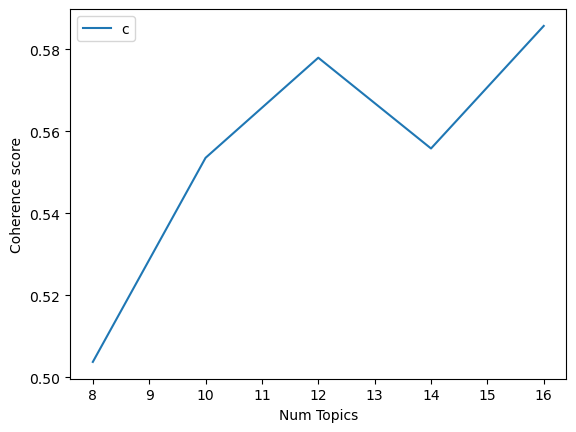

Num Topics = 8  has Coherence Value of 0.5037
Num Topics = 10  has Coherence Value of 0.5535
Num Topics = 12  has Coherence Value of 0.5779
Num Topics = 14  has Coherence Value of 0.5558
Num Topics = 16  has Coherence Value of 0.5857


In [72]:
limit=17; start=8; step=2;
def calculate_coherence(dictionary, corpus, texts, limit, start, step):
    coherences = []
    models = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=dictionary,
                                           num_topics=num_topics, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=1000,
                                           passes=50,
                                           alpha='auto',
                                           per_word_topics=True)
        models.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherences.append(coherencemodel.get_coherence())

    return models, coherences

# Time consuming task
start_time = time.time()
print ('Current datatime: {}'.format(datetime.datetime.now()))
models, coherences = calculate_coherence(dictionary=dict_wla, corpus=corpus_wla, texts=texts_wla, start=start, limit=limit, step=step)
end_time = time.time()
elapsed_time = end_time - start_time
print(f'Execution time: {elapsed_time:.2f} seconds')

# Show graph
#limit=70; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherences)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

# Print the coherence scores
for m, cv in zip(x, coherences):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

In [204]:
# Select the model and print the topics
#optimal_model = models[2]
#model_topics = optimal_model.show_topics(formatted=False)
#pprint(optimal_model.print_topics(num_words=10))

In [74]:
results_test["2.1.4"] = round(coherences[2],3)

!!! Save the best model

#### 2.1.5 Find the best model by varying the chunk size (white list of english words applied)

Current datatime: 2024-05-15 13:16:32.468403
Execution time: 1757.39 seconds


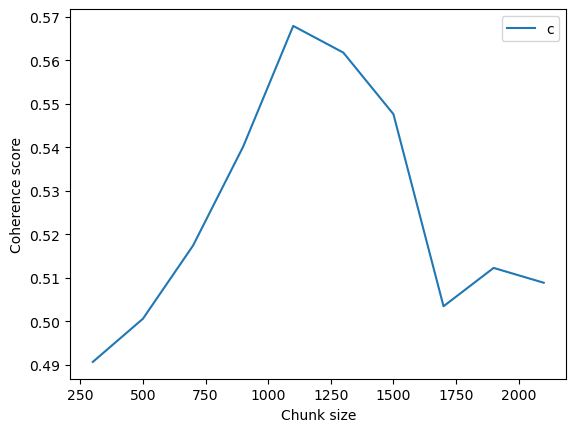

Chunk size = 300  has Coherence Value of 0.4907
Chunk size = 500  has Coherence Value of 0.5006
Chunk size = 700  has Coherence Value of 0.5174
Chunk size = 900  has Coherence Value of 0.5401
Chunk size = 1100  has Coherence Value of 0.5679
Chunk size = 1300  has Coherence Value of 0.5618
Chunk size = 1500  has Coherence Value of 0.5476
Chunk size = 1700  has Coherence Value of 0.5035
Chunk size = 1900  has Coherence Value of 0.5123
Chunk size = 2100  has Coherence Value of 0.5089


In [75]:
limit=2200; start=300; step=200;

def calculate_coherence(dictionary, corpus, texts, limit, start, step):
    coherences = []
    models = []
    for chunksize in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=dictionary,
                                           num_topics=12, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=chunksize,
                                           passes=50,
                                           alpha='auto',
                                           per_word_topics=True)
        models.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherences.append(coherencemodel.get_coherence())

    return models, coherences

# Time consuming task
start_time = time.time()
print ('Current datatime: {}'.format(datetime.datetime.now()))
models, coherences = calculate_coherence(dictionary=dict_wla, corpus=corpus_wla, texts=texts_wla, start=start, limit=limit, step=step)
end_time = time.time()
elapsed_time = end_time - start_time
print(f'Execution time: {elapsed_time:.2f} seconds')

# Show graph
#limit=70; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherences)
plt.xlabel("Chunk size")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

# Print the coherence scores
for m, cv in zip(x, coherences):
    print("Chunk size =", m, " has Coherence Value of", round(cv, 4))

#### 2.1.6 Let us try to find the best model (white list of english words applied)

In [81]:
# best wla
start_time = time.time()
print ('Current datatime: {}'.format(datetime.datetime.now()))
lda_model_wla = gensim.models.ldamodel.LdaModel(corpus=corpus_wla,
                                           id2word=dict_wla,
                                           num_topics=12, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=1300,
                                           passes=50,
                                           alpha='auto',
                                           per_word_topics=True)

end_time = time.time()
elapsed_time = end_time - start_time
print(f'Execution time: {elapsed_time:.2f} seconds')

Current datatime: 2024-05-15 15:53:23.303812
Execution time: 182.82 seconds


In [82]:
# Lets calculate the perplexity of the model
print('Model Perplexity: ', lda_model_wla.log_perplexity(corpus_wla))  # the lower the better.

# Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model_wla, texts=texts_wla, dictionary=dict_wla, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('Model Coherence Score: ', coherence_lda)

Model Perplexity:  -5.442514248093942
Model Coherence Score:  0.5617595783406928


In [83]:
results_test["2.1.6"] = round(coherence_lda,3)

In [84]:
results_test

{'2.1.1': 0.543,
 '2.1.2': 0.565,
 '2.1.3.1': 0.547,
 '2.1.3.2': 0.511,
 '2.1.4': 0.578,
 '2.1.6': 0.562}

In [205]:
#lda_model_wla.print_topics()

## 2.2 Let us work with all the english words ("white list is not applied", _aew)

In [85]:
def simple_tokenize(text):
    tokenized = [item for item in text.split(' ')]
    return tokenized

data['full_request_tokenized'] = data['full_request_modified_lem'].apply(simple_tokenize)

data_lemmatized_aew = data['full_request_tokenized']

# build the dictionary
dict_aew = corpora.Dictionary(data_lemmatized_aew)
# build the Corpus
texts_aew = data_lemmatized_aew

# corpus_wla = [dict_wla.doc2bow(text) for text in texts_wla]

# Term / document matrix
corpus_aew = [dict_aew.doc2bow(text) for text in texts_aew]


print("len data dict = ",len(dict_aew))
print("len of texts", len(texts_aew))
print("len of corpus", len(corpus_aew))

len data dict =  3909
len of texts 10795
len of corpus 10795


#### 2.2.1 First LDA model with all english words. (all english words)

In [86]:
# Try first LDA model
print ('Current datatime: {}'.format(datetime.datetime.now()))
start_time = time.time()
lda_model_aew_1 = gensim.models.ldamodel.LdaModel(corpus=corpus_aew,
                                           id2word=dict_aew,
                                           num_topics=20, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=500,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

end_time = time.time()
elapsed_time = end_time - start_time
print(f'Execution time: {elapsed_time:.2f} seconds')

Current datatime: 2024-05-15 17:23:25.423461
Execution time: 47.40 seconds


In [87]:
#  Lets calculate the perplexity of the model
print('Model Perplexity: ', lda_model_aew_1.log_perplexity(corpus_aew))  # the lower the better.

#  Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model_aew_1, texts=texts_aew, dictionary=dict_aew, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('Model Coherence Score: ', coherence_lda)

Model Perplexity:  -7.924653489024674
Model Coherence Score:  0.5280115784109382


In [88]:
results_test["2.2.1"] = round(coherence_lda,3)

In [206]:
#lda_model_aew_1.print_topics()

#### 2.2.2 Second model with 50 passes (all english words)

In [90]:
# Second model with 50 passes
print ('Current datatime: {}'.format(datetime.datetime.now()))
start_time = time.time()
lda_model_aew2 = gensim.models.ldamodel.LdaModel(corpus=corpus_aew,
                                           id2word=dict_aew,
                                           num_topics=20, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=500,
                                           passes=50,
                                           alpha='auto',
                                           per_word_topics=True)

end_time = time.time()
elapsed_time = end_time - start_time
print(f'Execution time: {elapsed_time:.2f} seconds')

Current datatime: 2024-05-15 17:24:36.240722
Execution time: 202.65 seconds


In [91]:
#  Perplexity
print('Model Perplexity: ', lda_model_aew2.log_perplexity(corpus_aew))  # the lower the better

#  Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model_aew2, texts=texts_aew, dictionary=dict_aew, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('Model Coherence Score: ', coherence_lda)

Model Perplexity:  -7.907713454435972
Model Coherence Score:  0.5274538207213293


In [92]:
results_test["2.2.2"] = round(coherence_lda,3)

#### 2.2.3. 3rd model, with increased chunk size (all english words)

In [93]:
# Second model with 50 passes
print ('Current datatime: {}'.format(datetime.datetime.now()))
start_time = time.time()
lda_model_aew3 = gensim.models.ldamodel.LdaModel(corpus=corpus_aew,
                                           id2word=dict_aew,
                                           num_topics=20, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=1000,
                                           passes=50,
                                           alpha='auto',
                                           per_word_topics=True)

end_time = time.time()
elapsed_time = end_time - start_time
print(f'Execution time: {elapsed_time:.2f} seconds')

Current datatime: 2024-05-15 17:28:19.247191
Execution time: 217.46 seconds


In [94]:
#  Perplexity
print('Model Perplexity: ', lda_model_aew3.log_perplexity(corpus_aew))  # the lower the better

#  Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model_aew3, texts=texts_aew, dictionary=dict_aew, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('Model Coherence Score: ', coherence_lda)

Model Perplexity:  -7.07259906559968
Model Coherence Score:  0.5090270811404997


In [95]:
results_test["2.2.3"] = coherence_lda

#### 2.2.4. Gensim. Find the best model by varying the parameter of topics number (all english words)

Current datatime: 2024-05-15 17:32:16.192337
Execution time: 832.69 seconds


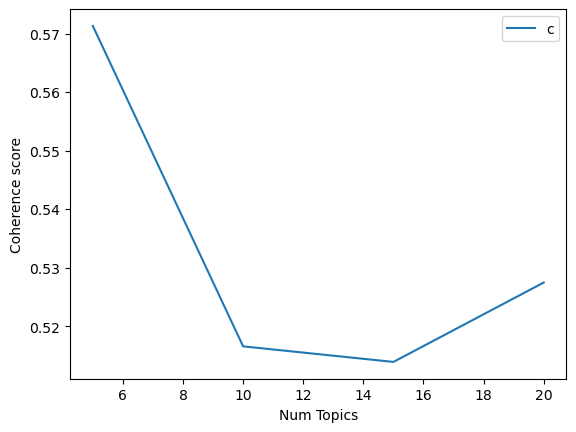

Num Topics = 5  has Coherence Value of 0.5713
Num Topics = 10  has Coherence Value of 0.5165
Num Topics = 15  has Coherence Value of 0.5139
Num Topics = 20  has Coherence Value of 0.5275


In [96]:
limit=21; start=5; step=5;
def calculate_coherence(dictionary, corpus, texts, limit, start, step):
    coherences = []
    models = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=dictionary,
                                           num_topics=num_topics, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=500,
                                           passes=50,
                                           alpha='auto',
                                           per_word_topics=True)
        models.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherences.append(coherencemodel.get_coherence())

    return models, coherences

# Time consuming task
start_time = time.time()
print ('Current datatime: {}'.format(datetime.datetime.now()))
models, coherences = calculate_coherence(dictionary=dict_aew, corpus=corpus_aew, texts=texts_aew, start=start, limit=limit, step=step)
end_time = time.time()
elapsed_time = end_time - start_time
print(f'Execution time: {elapsed_time:.2f} seconds')

# Show graph
#limit=70; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherences)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

# Print the coherence scores
for m, cv in zip(x, coherences):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

#### 2.2.5 Find the best model by varying the chunk size (all english words)

Current datatime: 2024-05-15 17:46:09.081555
Execution time: 1855.59 seconds


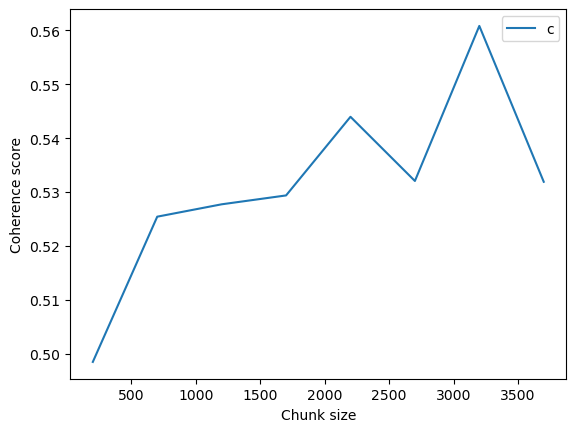

Chunk Size = 200  has Coherence Value of 0.4985
Chunk Size = 700  has Coherence Value of 0.5254
Chunk Size = 1200  has Coherence Value of 0.5277
Chunk Size = 1700  has Coherence Value of 0.5294
Chunk Size = 2200  has Coherence Value of 0.544
Chunk Size = 2700  has Coherence Value of 0.5321
Chunk Size = 3200  has Coherence Value of 0.5608
Chunk Size = 3700  has Coherence Value of 0.5319


In [97]:
limit=4100; start=200; step=500;

def calculate_coherence(dictionary, corpus, texts, limit, start, step):
    coherences = []
    models = []
    for chunksize in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=dictionary,
                                           num_topics=15, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=chunksize,
                                           passes=50,
                                           alpha='auto',
                                           per_word_topics=True)
        models.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherences.append(coherencemodel.get_coherence())

    return models, coherences

# Time consuming task
start_time = time.time()
print ('Current datatime: {}'.format(datetime.datetime.now()))
models, coherences = calculate_coherence(dictionary=dict_aew, corpus=corpus_aew, texts=texts_aew, start=start, limit=limit, step=step)
end_time = time.time()
elapsed_time = end_time - start_time
print(f'Execution time: {elapsed_time:.2f} seconds')

# Show graph
#limit=70; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherences)
plt.xlabel("Chunk size")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

# Print the coherence scores
for m, cv in zip(x, coherences):
    print("Chunk Size =", m, " has Coherence Value of", round(cv, 4))

#### 2.2.6 Find the optimal model

In [106]:
# Second model with 50 passes
print ('Current datatime: {}'.format(datetime.datetime.now()))
start_time = time.time()
lda_model_aew_6 = gensim.models.ldamodel.LdaModel(corpus=corpus_aew,
                                           id2word=dict_aew,
                                           num_topics=15, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=3200,
                                           passes=50,
                                           alpha='auto',
                                           per_word_topics=True)

end_time = time.time()
elapsed_time = end_time - start_time
print(f'Execution time: {elapsed_time:.2f} seconds')

Current datatime: 2024-05-15 20:37:05.904608
Execution time: 210.44 seconds


In [107]:
#  Perplexity
print('Model Perplexity: ', lda_model_aew_6.log_perplexity(corpus_aew))  # the lower the better

#  Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model_aew_6, texts=texts_aew, dictionary=dict_aew, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('Model Coherence Score: ', coherence_lda)

Model Perplexity:  -6.014837850004772
Model Coherence Score:  0.5608422644398324


In [108]:
results_test["2.2.6"] = round(coherence_lda,3)

In [105]:
results_test

{'2.1.1': 0.543,
 '2.1.2': 0.565,
 '2.1.3.1': 0.547,
 '2.1.3.2': 0.511,
 '2.1.4': 0.578,
 '2.1.6': 0.562,
 '2.2.1': 0.528,
 '2.2.2': 0.527,
 '2.2.3': 0.5090270811404997,
 '2.2.6': 0.542}

Result: we see that leaving all english words leads to slightly worse reults. So we will continue applying the white list of english words.

### 2.3. Optimize the data further and apply model

####  Let's try to futher optimize the initial data

a) take out n=1 symbol words if there are any  

b) get rid of the words with occurence = 1,2,3 in the whole corpus

c) take out requests which are less than 10 words inside

Note: we will add _opt suffix for doing so

#### 2.3.1. Delete n=1 symbols words

In [54]:
# function to delete n symbols words
def delete_n_symbols_word_print(text, n_symbols):
    try:
        text2list = text.split(' ')
    except Exception:
        print('Can not split text')   
    text_as_list = [word for word in text2list if len(word)>n_symbols]
    res = ' '.join(text_as_list)
    return res

In [56]:
# Lets delete 1 symbol words
#data['request_details_modified_lem_opt'] = data['request_details_modified_lem'].apply(lambda x: delete_n_symbols_word_print(x,1))
data['full_request_modified_lem_opt'] = data['full_request_modified_lem_allowed_eng_words'].apply(lambda x: delete_n_symbols_word_print(x,1))

#### 2.3.2. Calculate the requests length and take out less than 5 words requests

In [57]:
data['full_request_lem_opt_len'] = data['full_request_modified_lem_opt'].apply(lambda x: len(x))
# Lets get rid of requests less than 5 words
data_shortened = data[data['full_request_lem_opt_len']>5].copy()

#### 2.3.3. Delete low frequency words

In [58]:
# Dictionary and function to calculate the frequency
frequency_opt = defaultdict(int)
def calculate_word_frequency(text):
    text2list = text.split(' ')
    for token in text2list:
        frequency_opt[token]+=1

# Lets calculate the frequency of words using full_request lemmatized column
data_shortened['full_request_modified_lem_opt'].apply(calculate_word_frequency)

# Lets bulid auxilary dataframe to calculate the frequency 95% range
freq_opt_values = frequency_opt.values()
freq_opt_keys = frequency_opt.keys()
df_freq = pd.DataFrame()
df_freq = pd.concat([pd.Series(freq_opt_values), pd.Series(freq_opt_keys)], axis=1)
df_freq.columns = ['counts', 'word']

# Calculate the percentage (building Paretto rule)
summ = df_freq['counts'].sum()
df_freq['percent'] = df_freq['counts'].apply(lambda x: round(x/summ*100,4))
df_freq = df_freq.sort_values(by='counts', ascending=False)
df_freq['cumul_percent'] = 100*(df_freq.percent.cumsum() / df_freq.percent.sum())

#df_freq

stopwords_opt_95range = df_freq[df_freq['cumul_percent']>95]['word']
stopwords_opt_95range_set = set(stopwords_opt_95range)

In [59]:
# first two words add no meaning in the seence of the business problem we are dealing with
# base and data in russian are used together as Database
stopwords_opt_95range_set.update(set(['база', 'данных']))

In [60]:
# include 95range frequency stop words into overall stopwords set
stop_phrases_all_test.update(stopwords_opt_95range_set)

In [207]:
#data_shortened.head(1)

In [62]:
# finally, lets delete low frequency words from the dataset
start_time = time.time()
print ('Current datatime: {}'.format(datetime.datetime.now()))
data_shortened['full_request_modified_lem_opt']= data_shortened['full_request_modified_lem_opt'].apply(delete_stop_words)
end_time = time.time()
elapsed_time = end_time - start_time
print(f'Execution time: {elapsed_time:.2f} seconds')

Current datatime: 2024-05-15 22:25:21.002945
Execution time: 0.17 seconds


In [63]:
'''def form_stop_words_by_frequency(frequency_dict, lower_limit):
    stop_words_by_frequency=set()
    for k,v in frequency_dict.items():
        if v<=lower_limit:
            stop_words_by_frequency.add(k)
    return stop_words_by_frequency

stop_words_by_frequency_opt = form_stop_words_by_frequency(frequency_opt,1)
'''

'def form_stop_words_by_frequency(frequency_dict, lower_limit):\n    stop_words_by_frequency=set()\n    for k,v in frequency_dict.items():\n        if v<=lower_limit:\n            stop_words_by_frequency.add(k)\n    return stop_words_by_frequency\n\nstop_words_by_frequency_opt = form_stop_words_by_frequency(frequency_opt,1)\n'

In [208]:
#data_shortened.isna().sum()

In [65]:
data_shortened['request_tokenized'] = data_shortened['full_request_modified_lem_opt'].apply(simple_tokenize)

In [66]:
data_lemmatized_opt = data_shortened['request_tokenized']

In [67]:
# Build the dictionary
data_dict_opt = corpora.Dictionary(data_lemmatized_opt)
# Corpus
texts_opt = data_lemmatized_opt
# Term / document matrix
corpus_opt = [data_dict_opt.doc2bow(text) for text in texts_opt]
# View
#print(corpus[:1])

In [69]:
# Build the model using previous parameters
start_time = time.time()
print ('Current datatime: {}'.format(datetime.datetime.now()))
lda_model_opt = gensim.models.ldamodel.LdaModel(corpus=corpus_opt,
                                           id2word=data_dict_opt,
                                           num_topics=12, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=1000,
                                           passes=50,
                                           alpha='auto',
                                           per_word_topics=True)

end_time = time.time()
elapsed_time = end_time - start_time
print(f'Execution time: {elapsed_time:.2f} seconds')

Current datatime: 2024-05-15 22:27:52.986780
Execution time: 215.58 seconds


In [70]:
# вычислаяем сложность и согласованность
# Compute Lets calculate the perplexity of the model
print('Model Perplexity: ', lda_model_opt.log_perplexity(corpus_opt))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model_opt, texts=data_lemmatized_opt, dictionary=data_dict_opt, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('Model Coherence Score: ', coherence_lda)

Model Perplexity:  -5.086011891120887
Model Coherence Score:  0.5447176550427271


In [209]:
# посмотрим топики
#lda_model_opt.print_topics()

Current datatime: 2024-05-15 22:35:14.923526
Execution time: 1383.53 seconds


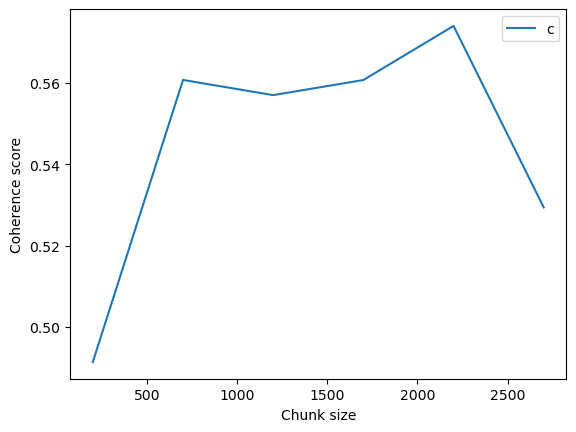

Chunk Size = 200  has Coherence Value of 0.4914
Chunk Size = 700  has Coherence Value of 0.5607
Chunk Size = 1200  has Coherence Value of 0.557
Chunk Size = 1700  has Coherence Value of 0.5607
Chunk Size = 2200  has Coherence Value of 0.574
Chunk Size = 2700  has Coherence Value of 0.5294


In [74]:
limit=3100; start=200; step=500;

def calculate_coherence(dictionary, corpus, texts, limit, start, step):
    coherences = []
    models = []
    for chunksize in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=dictionary,
                                           num_topics=12, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=chunksize,
                                           passes=50,
                                           alpha='auto',
                                           per_word_topics=True)
        models.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherences.append(coherencemodel.get_coherence())

    return models, coherences

# Time consuming task
start_time = time.time()
print ('Current datatime: {}'.format(datetime.datetime.now()))
models, coherences = calculate_coherence(dictionary=data_dict_opt, corpus=corpus_opt, texts=texts_opt, start=start, limit=limit, step=step)
end_time = time.time()
elapsed_time = end_time - start_time
print(f'Execution time: {elapsed_time:.2f} seconds')

# Show graph
#limit=70; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherences)
plt.xlabel("Chunk size")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

# Print the coherence scores
for m, cv in zip(x, coherences):
    print("Chunk Size =", m, " has Coherence Value of", round(cv, 4))

Current datatime: 2024-05-15 23:20:09.720273
Execution time: 878.06 seconds


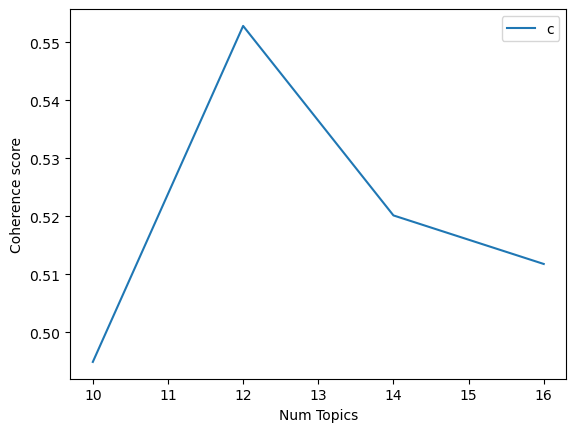

Num Topics = 10  has Coherence Value of 0.4949
Num Topics = 12  has Coherence Value of 0.5528
Num Topics = 14  has Coherence Value of 0.5202
Num Topics = 16  has Coherence Value of 0.5118


In [75]:
limit=17; start=10; step=2;
def calculate_coherence(dictionary, corpus, texts, limit, start, step):
    coherences = []
    models = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=dictionary,
                                           num_topics=num_topics, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=500,
                                           passes=50,
                                           alpha='auto',
                                           per_word_topics=True)
        models.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherences.append(coherencemodel.get_coherence())

    return models, coherences

# Time consuming task
start_time = time.time()
print ('Current datatime: {}'.format(datetime.datetime.now()))
models, coherences = calculate_coherence(dictionary=data_dict_opt, corpus=corpus_opt, texts=texts_opt, start=start, limit=limit, step=step)
end_time = time.time()
elapsed_time = end_time - start_time
print(f'Execution time: {elapsed_time:.2f} seconds')

# Show graph
#limit=70; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherences)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

# Print the coherence scores
for m, cv in zip(x, coherences):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

In [76]:
# Build the model using previous parameters
start_time = time.time()
print ('Current datatime: {}'.format(datetime.datetime.now()))
lda_model_opt_best = gensim.models.ldamodel.LdaModel(corpus=corpus_opt,
                                           id2word=data_dict_opt,
                                           num_topics=12, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=2200,
                                           passes=50,
                                           alpha='auto',
                                           per_word_topics=True)

end_time = time.time()
elapsed_time = end_time - start_time
print(f'Execution time: {elapsed_time:.2f} seconds')

Current datatime: 2024-05-15 23:38:09.176625
Execution time: 237.93 seconds


In [77]:
# вычислаяем сложность и согласованность
# Compute Lets calculate the perplexity of the model
print('Model Perplexity: ', lda_model_opt_best.log_perplexity(corpus_opt))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model_opt_best, texts=data_lemmatized_opt, dictionary=data_dict_opt, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('Model Coherence Score: ', coherence_lda)

Model Perplexity:  -5.026703404632835
Model Coherence Score:  0.5740312830954357


## 2.4. Lets do requests analysis

### We see that model with the white list applied (2.1.6) has the best coherence score 

#### 2.4.1 For each request let us find key topic, its probability and keywords

In [130]:
"""
# Lets calculate the perplexity of the model
print('Model Perplexity: ', lda_model_wla.log_perplexity(corpus_wla))  # the lower the better.

# Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model_wla, texts=texts_wla, dictionary=dict_wla, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('Model Coherence Score: ', coherence_lda)
"""
#We see that model with thee white list applid has the best cogherence score 

"\n# Lets calculate the perplexity of the model\nprint('Model Perplexity: ', lda_model_wla.log_perplexity(corpus_wla))  # the lower the better.\n\n# Coherence Score\ncoherence_model_lda = CoherenceModel(model=lda_model_wla, texts=texts_wla, dictionary=dict_wla, coherence='c_v')\ncoherence_lda = coherence_model_lda.get_coherence()\nprint('Model Coherence Score: ', coherence_lda)\n"

In [78]:
best_test_model = lda_model_wla
best_test_model_texts=texts_wla
best_test_model_dict = dict_wla
best_test_model_corpus = corpus_wla

NameError: name 'lda_model_wla' is not defined

In [132]:
import pandas as pd

In [133]:
#print(len(corpus))
#print(len(data_lemmatized))

In [135]:
"""
best_test_model = lda_model_wla
best_test_model_texts=texts_wla
best_test_model_dict = dict_wla
best_test_model_corpus = corpus_wla
"""

'\nbest_test_model = lda_model_wla\nbest_test_model_texts=texts_wla\nbest_test_model_dict = dict_wla\nbest_test_model_corpus = corpus_wla\n'

In [134]:
# Build topic keywords
def retrieve_topic_keywords_from_request(ldamodel, corpus, texts, num_topics, num_words):
    # Init output
    sent_topics_df = pd.DataFrame()
    temp_list = []
    
    # для каждого предложения - наиболее вероятные тема id, и ее вероятность
    topic_probability = ldamodel.get_document_topics(corpus, minimum_probability=None, minimum_phi_value=None, per_word_topics=False)

    # вывод наиболее значимых тем и слов к ним
    
    # Get main topic in each document
    for i in range(len(corpus)):  
        #row = sorted(topic_probability[i], key=lambda x: (x[1]), reverse=True)
        highest_topic_prob = sorted(topic_probability[i], key=lambda x: (x[1]), reverse=True)[0]
        topic_id = highest_topic_prob[0]
        probability = highest_topic_prob[1]
        
        words_with_probabilities = ldamodel.show_topic(topic_id)
        topic_keywords = ", ".join([word for word, prop in words_with_probabilities])
        temp_series = pd.DataFrame([[int(topic_id), round(probability,2), topic_keywords]])
        sent_topics_df = pd.concat([sent_topics_df, temp_series])
        #sent_topics_df = sent_topics_df.concat(pd.Series([int(topic_id), round(probability,2), topic_keywords]), ignore_index=True)

    sent_topics_df.columns = ['key_topic', 'topic_probability', 'top_keywords']

    # Add request as a column
    #requests = pd.DataFrame(texts)
    #result = pd.concat([sent_topics_df, requests], axis=1)
    
    return sent_topics_df

In [136]:
# Let us build the DataFrame with Topic overall probability, top keywords for each request
df_requests_topic_keywords_test = retrieve_topic_keywords_from_request(ldamodel=best_test_model, corpus=corpus_wla, 
                                                  texts=best_test_model_texts, num_topics = 15, num_words=10)
df_requests_topic_keywords_test.reset_index(drop=True, inplace = True)
req_test = pd.DataFrame(best_test_model_texts)
#req_test = df_4vasya
req_test.reset_index(drop=True, inplace = True)
analysis_test = pd.concat([df_requests_topic_keywords_test, req_test], axis=1)

In [137]:
analysis_test.isna().sum()

key_topic                     0
topic_probability             0
top_keywords                  0
full_request_wla_tokenized    0
dtype: int64

In [138]:
analysis_test.dropna(inplace = True)

In [139]:
#analysis_test.to_csv("4vasya_requests_with_topics_not_lemm.csv")

#### 2.4.2 Overall statistics for key topics

In [210]:

# # of docs for each topic
topic_counts_test = analysis_test['key_topic'].value_counts()
#topic_counts

# % of docs for each topic
topic_contribution_test = round(topic_counts_test/topic_counts_test.sum(), 4)
#topic_contribution

def build_topics(ldamodel):
    # Init output
    temp_df = pd.DataFrame()
    
    for topic_id in list(topic_counts_test.index):
        counts = topic_counts_test[topic_id]
        percent = topic_contribution_test[topic_id]
        words_with_probabilities = ldamodel.show_topic(topic_id)
        topic_keywords = ", ".join([word for word, prop in words_with_probabilities])
        row_df = pd.DataFrame([[int(topic_id), counts, percent, topic_keywords]])
        
        temp_df = pd.concat([temp_df, row_df], ignore_index=True)

    temp_df.columns = ['topic_id', 'counts', 'percent', 'keywords']
    return temp_df      

df_topics_counts_percent_test = build_topics(best_test_model)


'\n# # of docs for each topic\ntopic_counts_test = analysis_test[\'key_topic\'].value_counts()\n#topic_counts\n\n# % of docs for each topic\ntopic_contribution_test = round(topic_counts_test/topic_counts_test.sum(), 4)\n#topic_contribution\n\ndef build_topics(ldamodel):\n    # Init output\n    temp_df = pd.DataFrame()\n    \n    for topic_id in list(topic_counts_test.index):\n        counts = topic_counts_test[topic_id]\n        percent = topic_contribution_test[topic_id]\n        words_with_probabilities = ldamodel.show_topic(topic_id)\n        topic_keywords = ", ".join([word for word, prop in words_with_probabilities])\n        row_df = pd.DataFrame([[int(topic_id), counts, percent, topic_keywords]])\n        \n        temp_df = pd.concat([temp_df, row_df], ignore_index=True)\n\n    temp_df.columns = [\'topic_id\', \'counts\', \'percent\', \'keywords\']\n    return temp_df      \n\ndf_topics_counts_percent_test = build_topics(best_test_model)\n'

In [211]:
"""
for i in range(df_topics_counts_percent_test.shape[0]):
    percent = df_topics_counts_percent_test['percent'][i]
    counts = df_topics_counts_percent_test['counts'][i]
    keywords = df_topics_counts_percent_test['keywords'][i]
    print(i, " :  % = ", percent, " counts = ", counts, " keywords = ", keywords )
    print("---")
"""

'\nfor i in range(df_topics_counts_percent_test.shape[0]):\n    percent = df_topics_counts_percent_test[\'percent\'][i]\n    counts = df_topics_counts_percent_test[\'counts\'][i]\n    keywords = df_topics_counts_percent_test[\'keywords\'][i]\n    print(i, " :  % = ", percent, " counts = ", counts, " keywords = ", keywords )\n    print("---")\n'

## 2.5. Models with bigrams and trigrams

#### Prepare/convert the data

In [80]:
data_test = pd.read_excel('data_cleaned_lemmatized_stopwords_applied_meaningful_eng_words_1005.xlsx', sheet_name='Sheet1')

In [81]:
data_test.shape

(10795, 12)

In [83]:
def simple_tokenize(text):
    tokenized = [item for item in text.split(' ')]
    return tokenized

In [212]:
#data_test['full_request_modified_lem_allowed_eng_words'][0]

In [213]:
#data_test.isna().sum()

In [86]:
data_test.dropna(inplace=True)

We will usee "full_request_modified_lem_allowed_eng_words" column, because it showed better perplexity and coherence

In [87]:
data_test['full_request_tokenized'] = data_test['full_request_modified_lem_allowed_eng_words'].apply(simple_tokenize)

In [88]:
data_words_test = data_test['full_request_tokenized']

In [89]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words_test, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words_test], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

In [90]:
def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

In [91]:
data_words_bigrams_test = make_bigrams(data_words_test)

In [92]:
data_words_trigrams_test = make_trigrams(data_words_test)

###  2.5.1 Models with bigrams

####  Create dictionary, corpus, tdf

In [93]:
# Create Dictionary
id2word_bi_test = corpora.Dictionary(data_words_bigrams_test)
# Create Corpus
texts_bi_test = data_words_bigrams_test
# Term Document Frequency
corpus_bi_test = [id2word_bi_test.doc2bow(text) for text in texts_bi_test]

In [94]:
id2word_bi_test[10]

'метрика'

#### 2.5.1.1. First model with bigrams

In [103]:
lda_model_bigram1 = gensim.models.ldamodel.LdaModel(corpus=corpus_bi_test,
                                           id2word=id2word_bi_test,
                                           num_topics=15, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=500,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)


# Compute Lets calculate the perplexity of the model
print('Model Perplexity: ', lda_model_bigram1.log_perplexity(corpus_bi_test))  # a measure of how good the model is. lower the better.
# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model_bigram1, texts=texts_bi_test, dictionary= id2word_bi_test, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('Model Coherence Score: ', coherence_lda)

Model Perplexity:  -6.249427372510831
Model Coherence Score:  0.47702802927434


In [104]:
results_test["2.5.1.1"] = round(coherence_lda,3)

In [214]:
#lda_model_bigram1.print_topics()

#### 2.5.1.2 Second model with bigrams and with increased number of passes

In [106]:
lda_model_bigram2 = gensim.models.ldamodel.LdaModel(corpus=corpus_bi_test,
                                           id2word=id2word_bi_test,
                                           num_topics=15, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=500,
                                           passes=50,
                                           alpha='auto',
                                           per_word_topics=True)


# Compute Lets calculate the perplexity of the model
print('Model Perplexity: ', lda_model_bigram2.log_perplexity(corpus_bi_test))  # a measure of how good the model is. lower the better.
# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model_bigram2, texts=texts_bi_test, dictionary=id2word_bi_test, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('Model Coherence Score: ', coherence_lda)

Model Perplexity:  -6.209286700580603
Model Coherence Score:  0.49251385045589563


In [107]:
results_test["2.5.1.2"] = round(coherence_lda,3)

#### 2.5.1.3. Third model with bigrams and varied number of topics

In [100]:
start = 8
step = 2
limit = 15

def calculate_coherence(dictionary, corpus, texts, limit, start, step):
    coherences = []
    models = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=dictionary,
                                           num_topics=num_topics, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=700,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)
        models.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherences.append(coherencemodel.get_coherence())

    return models, coherences

In [101]:
# Time consuming task
start_time = time.time()
print ('Current datatime: {}'.format(datetime.datetime.now()))
models, coherences = calculate_coherence(dictionary=id2word_bi_test, corpus=corpus_bi_test, texts=texts_bi_test, start=start, limit=limit, step=step)
end_time = time.time()
elapsed_time = end_time - start_time
print(f'Execution time: {elapsed_time:.2f} seconds')


Current datatime: 2024-05-15 23:52:51.051384
Execution time: 206.88 seconds


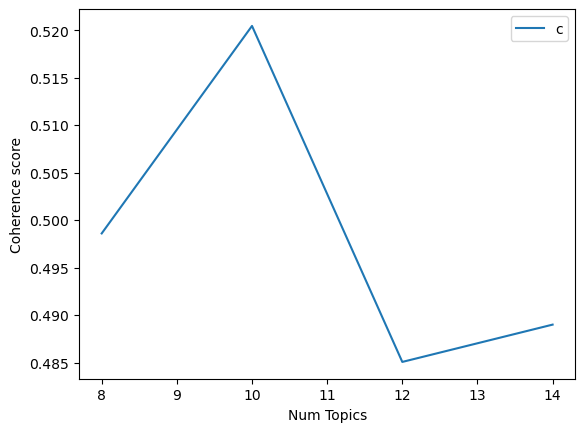

Num Topics = 8  has Coherence Value of 0.4986
Num Topics = 10  has Coherence Value of 0.5204
Num Topics = 12  has Coherence Value of 0.4851
Num Topics = 14  has Coherence Value of 0.489


In [102]:
# Show graph
#limit=30; start=5; step=5;
x = range(start, limit, step)
plt.plot(x, coherences)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

# Print the coherence scores
for m, cv in zip(x, coherences):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

#### 2.5.1.4. 4th model with bigrams and varying chunk size

Current datatime: 2024-05-16 00:07:51.275684
Execution time: 1304.69 seconds


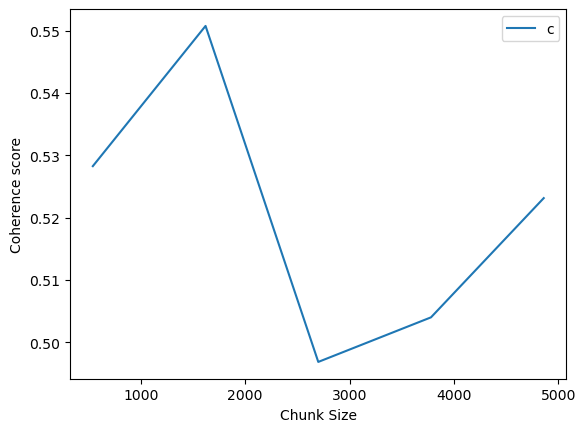

Chunk Size = 540  has Coherence Value of 0.5282
Chunk Size = 1620  has Coherence Value of 0.5507
Chunk Size = 2700  has Coherence Value of 0.4968
Chunk Size = 3780  has Coherence Value of 0.504
Chunk Size = 4860  has Coherence Value of 0.5231


In [108]:
limit = round(len(texts_bi_test)/2)
start = round(limit/10)
step = start*2


def calculate_coherence(dictionary, corpus, texts, limit, start, step):
    coherences = []
    models = []
    for chunksize in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=dictionary,
                                           num_topics=10, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=chunksize,
                                           passes=50,
                                           alpha='auto',
                                           per_word_topics=True)
        models.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherences.append(coherencemodel.get_coherence())

    return models, coherences

# Time consuming task
start_time = time.time()
print ('Current datatime: {}'.format(datetime.datetime.now()))
models, coherences = calculate_coherence(dictionary=id2word_bi_test, corpus=corpus_bi_test, texts=texts_bi_test, start=start, limit=limit, step=step)
end_time = time.time()
elapsed_time = end_time - start_time
print(f'Execution time: {elapsed_time:.2f} seconds')

# Show graph
#limit=30; start=5; step=5;
x = range(start, limit, step)
plt.plot(x, coherences)
plt.xlabel("Chunk Size")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

# Print the coherence scores
for m, cv in zip(x, coherences):
    print("Chunk Size =", m, " has Coherence Value of", round(cv, 4))

Current datatime: 2024-05-16 00:29:36.149993
Execution time: 1072.01 seconds


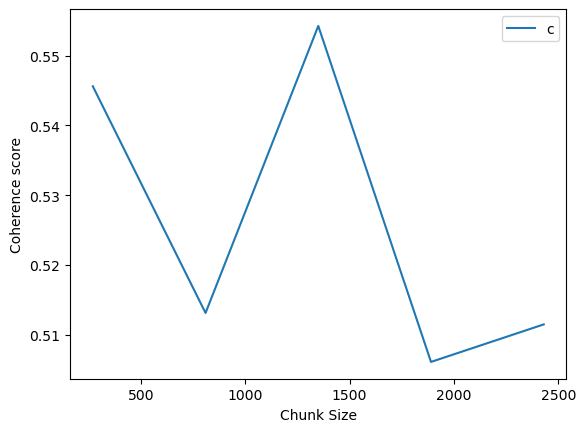

Chunk Size = 270  has Coherence Value of 0.5456
Chunk Size = 810  has Coherence Value of 0.5131
Chunk Size = 1350  has Coherence Value of 0.5543
Chunk Size = 1890  has Coherence Value of 0.5061
Chunk Size = 2430  has Coherence Value of 0.5115


In [109]:
limit = round(len(texts_bi_test)/4)
start = round(limit/10)
step = start*2

# Time consuming task
start_time = time.time()
print ('Current datatime: {}'.format(datetime.datetime.now()))
models, coherences = calculate_coherence(dictionary=id2word_bi_test, corpus=corpus_bi_test, texts=texts_bi_test, start=start, limit=limit, step=step)
end_time = time.time()
elapsed_time = end_time - start_time
print(f'Execution time: {elapsed_time:.2f} seconds')

# Show graph
#limit=30; start=5; step=5;
x = range(start, limit, step)
plt.plot(x, coherences)
plt.xlabel("Chunk Size")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

# Print the coherence scores
for m, cv in zip(x, coherences):
    print("Chunk Size =", m, " has Coherence Value of", round(cv, 4))

#### 2.5.1.5. Let us define the best bigram model

In [110]:
lda_model_bigram_best = gensim.models.ldamodel.LdaModel(corpus=corpus_bi_test,
                                           id2word=id2word_bi_test,
                                           num_topics=10, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=1300,
                                           passes=50,
                                           alpha='auto',
                                           per_word_topics=True)


lda_model_bigram_best.print_topics()

# Compute Lets calculate the perplexity of the model
print('Model Perplexity: ', lda_model_bigram_best.log_perplexity(corpus_bi_test))  # a measure of how good the model is. lower the better.
# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model_bigram_best, texts=texts_bi_test, dictionary=id2word_bi_test, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('Model Coherence Score: ', coherence_lda)

Model Perplexity:  -5.384158468760262
Model Coherence Score:  0.5557373368150459


In [111]:
results_test["2.5.1.5"] = coherence_model_lda.get_coherence()

In [112]:
#lda_model_bigram_best.print_topics()

### 2.5.2 Trigram model

In [113]:
# Create Dictionary
id2word_trigram_test = corpora.Dictionary(data_words_trigrams_test)
# Create Corpus
texts_trigram_test = data_words_trigrams_test
# Term Document Frequency
corpus_trigram_test = [id2word_trigram_test.doc2bow(text) for text in texts_trigram_test]

#### 2.5.2.1. First trigram model

In [114]:
lda_model_trigram1 = gensim.models.ldamodel.LdaModel(corpus=corpus_trigram_test,
                                           id2word=id2word_trigram_test,
                                           num_topics=20, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=500,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)
# Compute Lets calculate the perplexity of the model
print('Model Perplexity: ', lda_model_trigram1.log_perplexity(corpus_trigram_test))  # a measure of how good the model is. lower the better.
# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model_trigram1, texts=texts_trigram_test, dictionary=id2word_trigram_test, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('Model Coherence Score: ', coherence_lda)

Model Perplexity:  -6.868377894021322
Model Coherence Score:  0.4683707894919723


In [115]:
results_test["2.5.2.1"] = round(coherence_lda, 3)

In [215]:
#lda_model_trigram1.print_topics()

#### 2.5.2.2. Second trigram model, # passes increased

In [117]:
lda_model_trigram2 = gensim.models.ldamodel.LdaModel(corpus=corpus_trigram_test,
                                           id2word=id2word_trigram_test,
                                           num_topics=20, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=500,
                                           passes=50,
                                           alpha='auto',
                                           per_word_topics=True)

# Compute Lets calculate the perplexity of the model
print('Model Perplexity: ', lda_model_trigram2.log_perplexity(corpus_trigram_test))  # a measure of how good the model is. lower the better.
# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model_trigram2, texts=texts_trigram_test, dictionary=id2word_trigram_test, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('Model Coherence Score: ', coherence_lda)

Model Perplexity:  -6.855839435207245
Model Coherence Score:  0.4675128247857506


In [118]:
results_test["2.5.2.2"] = coherence_model_lda.get_coherence()

In [119]:
#lda_model_trigram2.print_topics()

#### 2.5.2.3. 3rd trigram model with varying # of topics

In [251]:
start = 5
step = 5
limit =31

def calculate_coherence(dictionary, corpus, texts, limit, start, step):
    coherences = []
    models = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=dictionary,
                                           num_topics=num_topics, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=500,
                                           passes=50,
                                           alpha='auto',
                                           per_word_topics=True)
        models.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherences.append(coherencemodel.get_coherence())

    return models, coherences

Current datatime: 2024-05-06 12:58:45.978399
Execution time: 1026.18 seconds


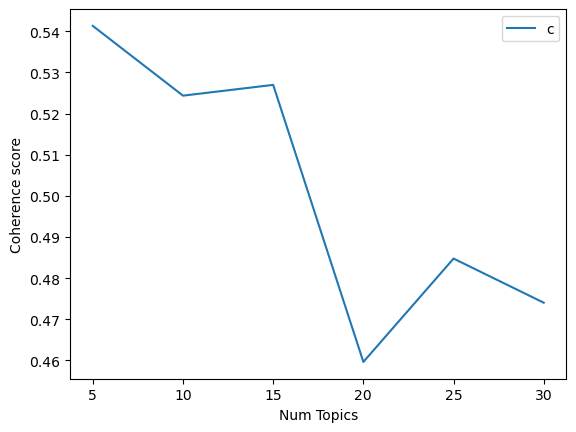

Num Topics = 5  has Coherence Value of 0.5413
Num Topics = 10  has Coherence Value of 0.5243
Num Topics = 15  has Coherence Value of 0.527
Num Topics = 20  has Coherence Value of 0.4596
Num Topics = 25  has Coherence Value of 0.4848
Num Topics = 30  has Coherence Value of 0.474


In [252]:
# Time consuming task
start_time = time.time()
print ('Current datatime: {}'.format(datetime.datetime.now()))
models, coherences = calculate_coherence(dictionary=id2word_trigram_test, corpus=corpus_trigram_test, texts=texts_trigram_test, start=start, limit=limit, step=step)
end_time = time.time()
elapsed_time = end_time - start_time
print(f'Execution time: {elapsed_time:.2f} seconds')

# Show graph
#limit=30; start=5; step=5;
x = range(start, limit, step)
plt.plot(x, coherences)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

# Print the coherence scores
for m, cv in zip(x, coherences):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

#### 2.5.2.4. 4th trigram model with varying cunksize

In [229]:
limit = round(len(texts_trigram_test)/2)
start = round(limit/10)
step = start*2

In [231]:
len(texts_trigram_test)

10080

In [235]:
def calculate_coherence(dictionary, corpus, texts, limit, start, step):
    coherences = []
    models = []
    for chunksize in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=dictionary,
                                           num_topics=10, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=chunksize,
                                           passes=50,
                                           alpha='auto',
                                           per_word_topics=True)
        models.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherences.append(coherencemodel.get_coherence())

    return models, coherences

Current datatime: 2024-05-06 11:08:03.904622
Execution time: 617.45 seconds


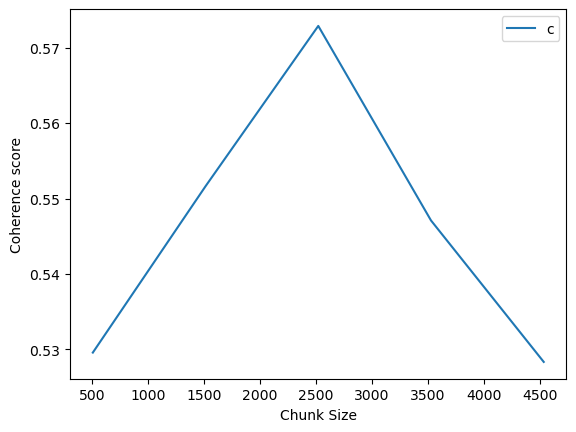

Chunk Size = 504  has Coherence Value of 0.5296
Chunk Size = 1512  has Coherence Value of 0.5516
Chunk Size = 2520  has Coherence Value of 0.5729
Chunk Size = 3528  has Coherence Value of 0.5471
Chunk Size = 4536  has Coherence Value of 0.5284


In [236]:
# Time consuming task
start_time = time.time()
print ('Current datatime: {}'.format(datetime.datetime.now()))
models, coherences = calculate_coherence(dictionary=id2word_trigram_test, corpus=corpus_trigram_test, texts=texts_trigram_test, start=start, limit=limit, step=step)
end_time = time.time()
elapsed_time = end_time - start_time
print(f'Execution time: {elapsed_time:.2f} seconds')

# Show graph
#limit=30; start=5; step=5;
x = range(start, limit, step)
plt.plot(x, coherences)
plt.xlabel("Chunk Size")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

# Print the coherence scores
for m, cv in zip(x, coherences):
    print("Chunk Size =", m, " has Coherence Value of", round(cv, 4))

In [238]:
limit = round(len(texts_trigram_test)/10)
start = round(limit/10)
step = start*2

Current datatime: 2024-05-06 11:19:01.779110
Execution time: 1349.43 seconds


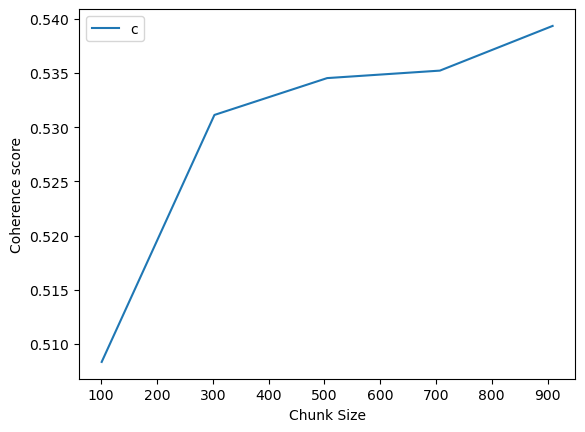

Chunk Size = 101  has Coherence Value of 0.5084
Chunk Size = 303  has Coherence Value of 0.5311
Chunk Size = 505  has Coherence Value of 0.5345
Chunk Size = 707  has Coherence Value of 0.5352
Chunk Size = 909  has Coherence Value of 0.5393


In [240]:
# Time consuming task
start_time = time.time()
print ('Current datatime: {}'.format(datetime.datetime.now()))
models, coherences = calculate_coherence(dictionary=id2word_trigram_test, corpus=corpus_trigram_test, texts=texts_trigram_test, start=start, limit=limit, step=step)
end_time = time.time()
elapsed_time = end_time - start_time
print(f'Execution time: {elapsed_time:.2f} seconds')

# Show graph
#limit=30; start=5; step=5;
x = range(start, limit, step)
plt.plot(x, coherences)
plt.xlabel("Chunk Size")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

# Print the coherence scores
for m, cv in zip(x, coherences):
    print("Chunk Size =", m, " has Coherence Value of", round(cv, 4))

#### 2.5.2.5. 5th trigram model, best

In [255]:
lda_model_trigram_best = gensim.models.ldamodel.LdaModel(corpus=corpus_trigram_test,
                                           id2word=id2word_trigram_test,
                                           num_topics=15, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=2500,
                                           passes=50,
                                           alpha='auto',
                                           per_word_topics=True)

# Compute Lets calculate the perplexity of the model
print('Model Perplexity: ', lda_model_trigram_best.log_perplexity(corpus_trigram_test))  # a measure of how good the model is. lower the better.
# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model_trigram_best, texts=texts_trigram_test, dictionary=id2word_trigram_test, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('Model Coherence Score: ', coherence_lda)

Model Perplexity:  -5.5275776223156035
Model Coherence Score:  0.5311510099094393


In [256]:
results_test["2.5.2.5"] = round(coherence_lda, 3)

In [216]:
#lda_model_trigram_best.print_topics()

In [258]:
# Save model to disk.
temp_file = datapath("mybest_bigram_model")
lda_model_bigram_best.save(temp_file)
# Load a potentially pretrained model from disk.

In [259]:
# Save model to disk.
temp_file = datapath("mybest_trigram_model")
lda_model_trigram_best.save(temp_file)
# Load a potentially pretrained model from disk.
my_model = gensim.models.ldamodel.LdaModel.load(temp_file)

# Part 2. Full data models

## 1. Handle the data

### 1.1 Let us load the full data

In [120]:
df_full = pd.read_excel('file2_1205.xlsx', sheet_name='Sheet1')

In [217]:
#df_full.head(1)

In [122]:
data_full = df_full[df_full['Категория']=='Запрос информации'][["ЗНО","Тема ЗНО", "Информация", "Дата регистрации"]].copy()

In [123]:
data_full["full_request"] = data_full["Тема ЗНО"] +' '+ data_full["Информация"]

### 1.2 Let us load the full data

In [124]:
# 1. converting abbreviations 
data_full['full_request_modified']= data_full['full_request'].apply(abbreviations_conversion)

In [218]:
"""for i in range(10):
    print(i, " ---")
    print(data_full['full_request_modified'][i])
    print("")
"""

'for i in range(10):\n    print(i, " ---")\n    print(data_full[\'full_request_modified\'][i])\n    print("")\n'

### 1.3 Eliminate digits, ips

In [126]:
# 2. Eliminating digits, ips
data_full['full_request_modified']= data_full['full_request_modified'].apply(remove_digits_emails_ips)

In [219]:
"""for i in range(10):
    print(i, " ---")
    print(data_full['full_request_modified'][i])
    print("")
    """

'for i in range(10):\n    print(i, " ---")\n    print(data_full[\'full_request_modified\'][i])\n    print("")\n    '

### 1.4 Eliminate one symbol word

In [128]:
# 3. Delete one symbol words
data_full['full_request_modified']= data_full['full_request_modified'].apply(lambda x: delete_n_symbols_word(x,1))

In [220]:
"""for i in range(10):
    print("---")
    print(i, ": len = ", len(data_full['full_request_modified'][i]))
    print(data_full['full_request_modified'][i])
    """

'for i in range(10):\n    print("---")\n    print(i, ": len = ", len(data_full[\'full_request_modified\'][i]))\n    print(data_full[\'full_request_modified\'][i])\n    '

In [130]:
#dfff = pd.concat([data_full, ZNO], axis=1)

In [131]:
#dfff.head(1)

In [132]:
#ZNO = data_full['ЗНО']

### 1.5 Lemmatize "full request" field

In [133]:
# 4. Lemmatize full request
start_time = time.time()
print ('Current datatime: {}'.format(datetime.datetime.now()))
data_full['full_request_modified_lem']= data_full['full_request_modified'].apply(lemmatize_en_ru)
end_time = time.time()
elapsed_time = end_time - start_time
print(f'Execution time: {elapsed_time:.2f} seconds')

Current datatime: 2024-05-16 02:26:02.885082


NameError: name 'lemmatize_en_ru' is not defined

In [ ]:
for i in range(10):
    print(i, ": len = ", len(data_full['full_request_modified_lem'][i]))
    print(data_full['full_request_modified_lem'][i])
    print("")

In [134]:
#data_full.to_excel(r'data_full_cleaned_lemmatized_1405.xlsx')
data_full = pd.read_excel('data_full_cleaned_lemmatized_stopwords_applied_with_date_0805.xlsx', sheet_name='Sheet1')

### 1.6 Calculate the frequency

In [135]:
# 5. Calculate the frequencey
full_frequency = defaultdict(int)
def calculate_word_full_frequency(text, dictionary):
    text2list = text.split(' ')
    for token in text2list:
        full_frequency[token]+=1

In [136]:
# calculate frequency
data_full['full_request_modified_lem'].apply(lambda x: calculate_word_full_frequency(x, full_frequency))

0        None
1        None
2        None
3        None
4        None
         ... 
43402    None
43403    None
43404    None
43405    None
43406    None
Name: full_request_modified_lem, Length: 43407, dtype: object

In [221]:
#[x for x in sorted(full_frequency.items(), key=lambda x: x[1], reverse = True)]

In [138]:
hf_stop_words_full_set = set(["база", "данных","ru", "sbrf", "если", "или", "вы", "pprb", "под", "прошу", "на", "не", "ru", "если", "или", "то", "*", 
                              "вы", "tvldd", "pprb", "pangolin", "tklid", "pvlad", "pvlod", "tvlad", "in", "tkldd", "sberbank", "нет"])

In [139]:
# load stop words from nltk
stopwords_eng = set(nltk_stopwords.words('english'))
stopwords_rus = set(nltk_stopwords.words('russian'))
nltk_stopwords_general = stopwords_eng.union(stopwords_rus)

In [140]:
# Add some seen words which carry no sense
stop_phrases_spec = ["добрый", "день", "вечер", "уважаемый", "коллеги", "спасибо", "заранее", "пожалуйста", "sbrf", "ru", 
                "https","support_PostgreSQL_sbt@sberbank.ru","https://confluence.ca.sbrf.ru/pages/viewpage.action?pageId=8049721948",
                "https://sbtatlas.sigma.sbrf.ru/wiki/pages/viewpage.action?pageId=1214912031",
                "[10.62.55.109]","SberEdition","Sberbank", "коллега", "sber", "прошу", "просить", "здравствовать", "просьба"]

stop_phrases_specific = [item.lower() for item in stop_phrases_spec]
stop_phrases_all = nltk_stopwords_general.union(set(stop_phrases_specific))

In [141]:
# Exclude no sense words as well
cust_set = set(['база', 'баз', ',базы', 'данных', 'данные'])
stop_phrases_all.update(cust_set)
stop_phrases_all.update(hf_stop_words_full_set)

### 1.6 Eliminate <=5 time occuring words

In [142]:
# 6. Eliminate <=5 time occuring words 
def form_stop_words_by_frequency_less_than_5(frequency_dict, lower_limit):
    stop_words_by_frequency=set()
    for k,v in frequency_dict.items():
        if v<=lower_limit:
            stop_words_by_frequency.add(k)
    return stop_words_by_frequency

In [143]:
stop_words_full_by_frequency_5_times = form_stop_words_by_frequency_less_than_5(full_frequency,5)

In [144]:
stop_phrases_all.update(stop_words_full_by_frequency_5_times)

In [145]:
len(stop_phrases_all)

15029

In [146]:
stop_phrases_all_list = list(stop_phrases_all)

In [147]:
with open('stop_phrases_all.pickle', 'wb') as file:
    # Serialize the list and write it to the file
    pickle.dump(stop_phrases_all_list, file)
# Close the file
file.close()

In [148]:
"""import pickle
# Define the list to be saved
my_list = [1, 2, 3, 4, 5]
# Open the file for writing
with open('my_list.pickle', 'wb') as file:
    # Serialize the list and write it to the file
    pickle.dump(my_list, file)
# Close the file
file.close()


# Open the file for reading
with open('my_list.pickle', 'rb') as file:
    # Deserialize the list and assign it to a variable
    my_loaded_list = pickle.load(file)
# Print the loaded list
print(my_loaded_list)
"""

"import pickle\n# Define the list to be saved\nmy_list = [1, 2, 3, 4, 5]\n# Open the file for writing\nwith open('my_list.pickle', 'wb') as file:\n    # Serialize the list and write it to the file\n    pickle.dump(my_list, file)\n# Close the file\nfile.close()\n\n\n# Open the file for reading\nwith open('my_list.pickle', 'rb') as file:\n    # Deserialize the list and assign it to a variable\n    my_loaded_list = pickle.load(file)\n# Print the loaded list\nprint(my_loaded_list)\n"

### 1.7 Apply stop words

In [149]:
def delete_stop_words_not_in_phrases_all(text):
    modified_x = [item for item in text.split(' ') if item not in stop_phrases_all]
    no_stop_words_text = ' '.join(modified_x)
    return no_stop_words_text

In [150]:
# 6. Lets apply stop words
print ('Current datatime: {}'.format(datetime.datetime.now()))
start_time = time.time()
data_full['full_request_modified_lem_stop_words_applied'] = data_full['full_request_modified_lem'].apply(delete_stop_words_not_in_phrases_all)
end_time = time.time()
elapsed_time = end_time - start_time
print(f'Execution time: {elapsed_time:.2f} seconds')

Current datatime: 2024-05-16 02:27:15.548492
Execution time: 0.92 seconds


In [151]:
len(stop_phrases_all)

15029

#### !!! save full cleaned and lemmatized data

In [83]:
data_full.to_excel(r'data_full_cleaned_lemmatized_stopwords_applied_with_date_0805.xlsx')
#data_full = pd.read_excel('data_full_cleaned_lemmatized_stopwords_applied_with_date_0805.xlsx', sheet_name='Sheet1')

In [148]:
data_full.shape

(43407, 9)

In [85]:
#ZNO.shape

In [86]:
#data_full.shape

In [87]:
#dfff =  pd.concat([data_full, ZNO], axis=1)

In [88]:
#data_full = dfff.copy()

In [222]:
#data_full.head(1)

In [153]:
data_full.isna().sum()

Unnamed: 0                                       0
ЗНО                                              0
Тема ЗНО                                         0
Информация                                      92
Дата регистрации                                 0
full_request                                     0
full_request_modified                            0
full_request_modified_lem                        0
full_request_modified_lem_stop_words_applied     0
dtype: int64

In [154]:
data_full.dropna(inplace=True)

In [155]:
# 7. Calculate the frequencey
frequency_full_after_lem = defaultdict(int)
def calculate_word_frequency_after_lem(text):
    text2list = text.split(' ')
    for token in text2list:
        frequency_full_after_lem[token]+=1

In [156]:
# calculate frequency
data_full['full_request_modified_lem_stop_words_applied'].apply(calculate_word_frequency_after_lem)

0        None
1        None
2        None
3        None
4        None
         ... 
43402    None
43403    None
43404    None
43405    None
43406    None
Name: full_request_modified_lem_stop_words_applied, Length: 43315, dtype: object

In [157]:
#frequency_full_after_lemm

In [158]:
#[x for x in sorted(frequency_full_after_lem.items(), key=lambda x: x[1], reverse = True)]

In [159]:
additional_stop_words = set(["*", "pangolin", "postgresql", "tvldd", "delta", "se", "tklid", "pvlad", "pvlod", "это", "коллега", "tvlad", "efs", "openshift"])

In [160]:
stop_phrases_all.update(additional_stop_words)

In [161]:
len(stop_phrases_all)

15035

In [162]:
# 8. Lets apply stop words
print ('Current datatime: {}'.format(datetime.datetime.now()))
start_time = time.time()
data_full['full_request_modified_lem_stop_words_applied'] = data_full['full_request_modified_lem_stop_words_applied'].apply(delete_stop_words_not_in_phrases_all)
end_time = time.time()
elapsed_time = end_time - start_time
print(f'Execution time: {elapsed_time:.2f} seconds')

Current datatime: 2024-05-16 02:27:47.200683
Execution time: 0.69 seconds


In [163]:
# Dictionary and function to calculate the frequency
full_set_frequency = defaultdict(int)
def calculate_word_frequency_full_set(text):
    text2list = text.split(' ')
    for token in text2list:
        full_set_frequency[token]+=1

In [164]:
# Lets calculate the frequency of words using full_request lemmatized column
data_full['full_request_modified_lem_stop_words_applied'].apply(calculate_word_frequency_full_set)

0        None
1        None
2        None
3        None
4        None
         ... 
43402    None
43403    None
43404    None
43405    None
43406    None
Name: full_request_modified_lem_stop_words_applied, Length: 43315, dtype: object

In [165]:
#full_set_frequency

### 1.8 Leave only 95% percentile words

In [166]:
# Lets bulid auxilary dataframe to calculate the frequency 95% range
full_set_frequency_values = full_set_frequency.values()
full_set_frequency_keys = full_set_frequency.keys()
full_set_df_freq = pd.DataFrame()
full_set_df_freq = pd.concat([pd.Series(full_set_frequency_values), pd.Series(full_set_frequency_keys)], axis=1)
full_set_df_freq.columns = ['counts', 'word']

In [167]:
# Calculate the percentage (building Paretto rule)
summ = full_set_df_freq['counts'].sum()
full_set_df_freq['percent'] = full_set_df_freq['counts'].apply(lambda x: round(x/summ*100,4))
full_set_df_freq = full_set_df_freq.sort_values(by='counts', ascending=False)
full_set_df_freq['cumul_percent'] = 100*(full_set_df_freq.percent.cumsum() / full_set_df_freq.percent.sum())

In [223]:
#full_set_df_freq.head(30)

In [224]:
#full_set_df_freq.tail(30)

In [170]:
full_set_stopwords_opt_95range = full_set_df_freq[full_set_df_freq['cumul_percent']>95]['word']
full_set_stopwords_opt_95range_set = set(full_set_stopwords_opt_95range)

In [171]:
stop_phrases_all.update(full_set_stopwords_opt_95range_set)

In [172]:
stop_phrases_all.update(set(["pg", "postgresql", "pplad"]))

In [173]:
# 8. Lets apply stop words
print ('Current datatime: {}'.format(datetime.datetime.now()))
start_time = time.time()
data_full['full_request_modified_lem_stop_words_applied'] = data_full['full_request_modified_lem_stop_words_applied'].apply(delete_stop_words_not_in_phrases_all)
end_time = time.time()
elapsed_time = end_time - start_time
print(f'Execution time: {elapsed_time:.2f} seconds')

Current datatime: 2024-05-16 02:27:56.980809
Execution time: 0.63 seconds


In [225]:
"""for i in range(10):
    print("---")
    print(i, ": len = ", len(data_full['full_request_modified_lem_stop_words_applied'][i]))
    print(data_full['full_request_modified_lem_stop_words_applied'][i])
    """

'for i in range(10):\n    print("---")\n    print(i, ": len = ", len(data_full[\'full_request_modified_lem_stop_words_applied\'][i]))\n    print(data_full[\'full_request_modified_lem_stop_words_applied\'][i])\n    '

### 1.9 Let us apply bigramm model

In [175]:
data_full['full_request_tokenized'] = data_full['full_request_modified_lem_stop_words_applied'].apply(simple_tokenize)

In [176]:
data_full.shape

(43315, 10)

In [177]:
data_words = data_full['full_request_tokenized']

# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=7, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
#trigram_mod = gensim.models.phrases.Phraser(trigram)

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

full_data_words_bigrams = make_bigrams(data_words)

# Build Dictionary
id2word = corpora.Dictionary(full_data_words_bigrams)
# Build Corpus
texts = full_data_words_bigrams
# Build Term Document Matrix
corpus = [id2word.doc2bow(text) for text in texts]


#### 1.9.1 First probe model for the full dataset

In [151]:
# first probe model
probe_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                   id2word=id2word,
                                   num_topics=15, 
                                   random_state=100,
                                   update_every=1,
                                   chunksize=500,
                                   passes=30,
                                   alpha='auto',
                                   per_word_topics=True)

#  Lets calculate the perplexity of the model
print('Model Perplexity: ', probe_model.log_perplexity(corpus))  # the lower the better

#  Coherence Score
coherence_model_lda = CoherenceModel(model=probe_model, texts=texts, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('Model Coherence Score: ', coherence_lda)

Model Perplexity:  -5.995968043955585
Model Coherence Score:  0.5657664963344592


In [152]:
results_full = {}

In [153]:
results_full["1.9"] = round(coherence_lda, 3)

In [226]:
#probe_model.print_topics()

### 1.10 Lets find the optimal number of topics

In [298]:
start = 8
step = 3
limit = 21

def calculate_coherence(dictionary, corpus, texts, limit, start, step):
    coherences = []
    models = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=num_topics, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=700,
                                           passes=30,
                                           alpha='auto',
                                           per_word_topics=True)
        models.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=id2word, coherence='c_v')
        coherences.append(coherencemodel.get_coherence())

    return models, coherences

In [299]:
# Time consuming task
start_time = time.time()
print ('Current datatime: {}'.format(datetime.datetime.now()))
models, coherences = calculate_coherence(dictionary=id2word, corpus=corpus, texts=texts, start=start, limit=limit, step=step)
end_time = time.time()
elapsed_time = end_time - start_time
print(f'Execution time: {elapsed_time:.2f} seconds')

Current datatime: 2024-05-13 22:24:53.007630
Execution time: 2388.00 seconds


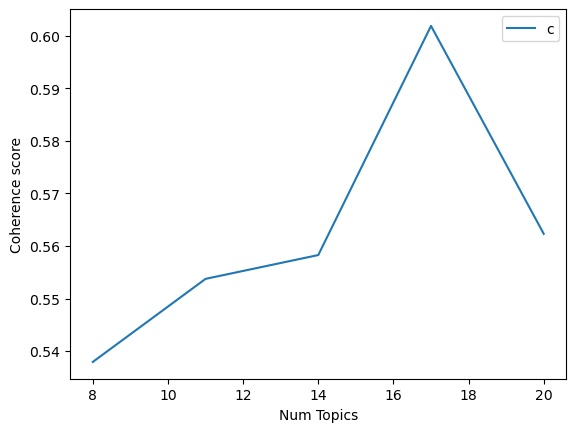

In [300]:
# Show graph
#limit=30; start=5; step=5;
x = range(start, limit, step)
plt.plot(x, coherences)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [301]:
# Print the coherence scores
for m, cv in zip(x, coherences):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 8  has Coherence Value of 0.5379
Num Topics = 11  has Coherence Value of 0.5537
Num Topics = 14  has Coherence Value of 0.5583
Num Topics = 17  has Coherence Value of 0.6019
Num Topics = 20  has Coherence Value of 0.5623


Lets use 15 topics further

### 1.11 Lets find the optimal chunk size

Part 1:

In [302]:
len(data_words)

43407

In [303]:
limit = round(len(data_words)/3)+1000
start = 700
temp = round(limit/10)
step = 5000
print("limit: ", limit, "start: ", start, "step: ",step)

limit:  15469 start:  700 step:  5000


In [304]:
def calculate_coherence(dictionary, corpus, texts, limit, start, step):
    coherences = []
    models = []
    for chunksize in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=17, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=chunksize,
                                           passes=50,
                                           alpha='auto',
                                           per_word_topics=True)
        models.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=id2word, coherence='c_v')
        coherences.append(coherencemodel.get_coherence())

    return models, coherences

In [305]:
# Time consuming task
start_time = time.time()
print ('Current datatime: {}'.format(datetime.datetime.now()))
models, coherences = calculate_coherence(dictionary=id2word, corpus=corpus, texts=texts, start=start, limit=limit, step=step)
end_time = time.time()
elapsed_time = end_time - start_time
print(f'Execution time: {elapsed_time:.2f} seconds')

Current datatime: 2024-05-13 23:04:41.328020
Execution time: 2570.90 seconds


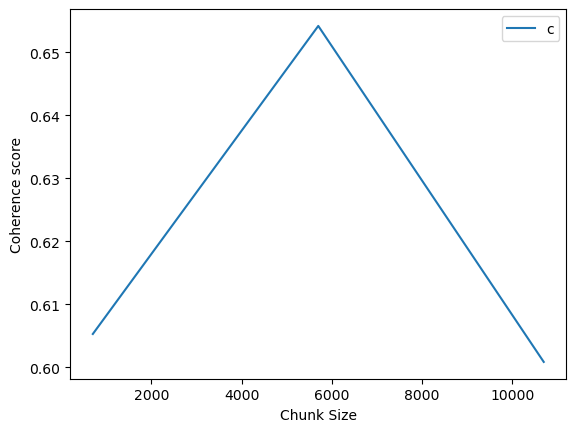

In [306]:
# Show graph
#limit=30; start=5; step=5;
x = range(start, limit, step)
plt.plot(x, coherences)
plt.xlabel("Chunk Size")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [307]:
# Print the coherence scores
for m, cv in zip(x, coherences):
    print("Chunk Size =", m, " has Coherence Value of", round(cv, 4))

Chunk Size = 700  has Coherence Value of 0.6053
Chunk Size = 5700  has Coherence Value of 0.6542
Chunk Size = 10700  has Coherence Value of 0.6009


Part 2

In [308]:
limit = 5000
start = 300
temp = round(limit/20)
step = 200
print("limit: ", limit, "start: ", start, "step: ",step)

limit:  5000 start:  300 step:  200


In [309]:
# Time consuming task
start_time = time.time()
print ('Current datatime: {}'.format(datetime.datetime.now()))
models, coherences = calculate_coherence(dictionary=id2word, corpus=corpus, texts=texts, start=start, limit=limit, step=step)
end_time = time.time()
elapsed_time = end_time - start_time
print(f'Execution time: {elapsed_time:.2f} seconds')

Current datatime: 2024-05-13 23:47:32.480711
Execution time: 21977.91 seconds


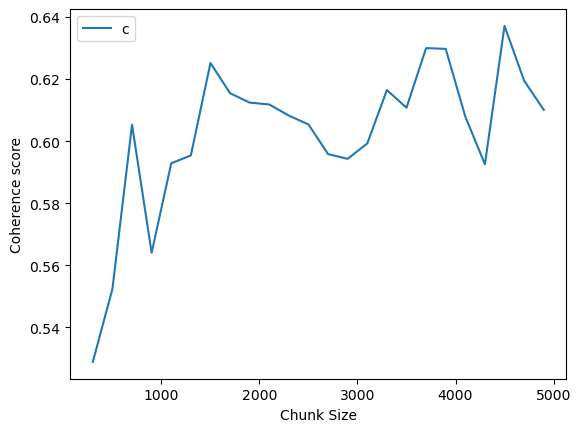

In [310]:
# Show graph
#limit=30; start=5; step=5;
x = range(start, limit, step)
plt.plot(x, coherences)
plt.xlabel("Chunk Size")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [311]:
# Print the coherence scores
for m, cv in zip(x, coherences):
    print("Chunk Size =", m, " has Coherence Value of", round(cv, 4))

Chunk Size = 300  has Coherence Value of 0.5289
Chunk Size = 500  has Coherence Value of 0.5524
Chunk Size = 700  has Coherence Value of 0.6053
Chunk Size = 900  has Coherence Value of 0.564
Chunk Size = 1100  has Coherence Value of 0.5929
Chunk Size = 1300  has Coherence Value of 0.5954
Chunk Size = 1500  has Coherence Value of 0.6252
Chunk Size = 1700  has Coherence Value of 0.6155
Chunk Size = 1900  has Coherence Value of 0.6124
Chunk Size = 2100  has Coherence Value of 0.6118
Chunk Size = 2300  has Coherence Value of 0.6082
Chunk Size = 2500  has Coherence Value of 0.6054
Chunk Size = 2700  has Coherence Value of 0.5958
Chunk Size = 2900  has Coherence Value of 0.5943
Chunk Size = 3100  has Coherence Value of 0.5993
Chunk Size = 3300  has Coherence Value of 0.6165
Chunk Size = 3500  has Coherence Value of 0.6108
Chunk Size = 3700  has Coherence Value of 0.63
Chunk Size = 3900  has Coherence Value of 0.6297
Chunk Size = 4100  has Coherence Value of 0.6079
Chunk Size = 4300  has Cohe

### Chunk size = 5700, n_topics =14

In [178]:
# first probe model
full_best_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                   id2word=id2word,
                                   num_topics=14, 
                                   random_state=100,
                                   update_every=1,
                                   chunksize=5700,
                                   passes=50,
                                   alpha='auto',
                                   per_word_topics=True)

In [179]:
len(corpus)

43315

In [180]:
#  Lets calculate the perplexity of the model
print('Model Perplexity: ', full_best_model.log_perplexity(corpus))  # the lower the better

#  Coherence Score
coherence_model_lda = CoherenceModel(model=full_best_model, texts=texts, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('Model Coherence Score: ', coherence_lda)

Model Perplexity:  -5.183570743618501
Model Coherence Score:  0.6533223038040669


In [227]:
#full_best_model.print_topics()

In [187]:
temp_file = datapath("full_best_model")
full_best_model.save(temp_file)

#### ---------

In [188]:
"""
# Build Dictionary
id2word = corpora.Dictionary(full_data_words_bigrams)
# Build Corpus
texts = full_data_words_bigrams
# Build Term Document Matrix
corpus = [id2word.doc2bow(text) for text in texts]
"""

'\n# Build Dictionary\nid2word = corpora.Dictionary(full_data_words_bigrams)\n# Build Corpus\ntexts = full_data_words_bigrams\n# Build Term Document Matrix\ncorpus = [id2word.doc2bow(text) for text in texts]\n'

In [189]:
# Build topic keywords
def retrieve_topic_keywords_from_request(ldamodel, corpus, texts, num_topics, num_words):
    # Init output
    sent_topics_df = pd.DataFrame()
    temp_list = []
    
    # для каждого предложения - наиболее вероятные тема id, и ее вероятность
    topic_probability = ldamodel.get_document_topics(corpus, minimum_probability=None, minimum_phi_value=None, per_word_topics=False)

    # вывод наиболее значимых тем и слов к ним
    
    # Get main topic in each document
    for i in range(len(corpus)):  
        #row = sorted(topic_probability[i], key=lambda x: (x[1]), reverse=True)
        highest_topic_prob = sorted(topic_probability[i], key=lambda x: (x[1]), reverse=True)[0]
        topic_id = highest_topic_prob[0]
        probability = highest_topic_prob[1]
        
        words_with_probabilities = ldamodel.show_topic(topic_id)
        topic_keywords = ", ".join([word for word, prop in words_with_probabilities])
        temp_series = pd.DataFrame([[int(topic_id), round(probability,2), topic_keywords]])
        sent_topics_df = pd.concat([sent_topics_df, temp_series])
        #sent_topics_df = sent_topics_df.concat(pd.Series([int(topic_id), round(probability,2), topic_keywords]), ignore_index=True)

    sent_topics_df.columns = ['key_topic', 'topic_probability', 'top_keywords']

    # Add request as a column
    #requests = pd.DataFrame(texts)
    #result = pd.concat([sent_topics_df, requests], axis=1)
    
    return sent_topics_df

# Let us build the DataFrame with Topic overall probability, top keywords for each request
df_requests_topic_keywords_full = retrieve_topic_keywords_from_request(ldamodel=full_best_model, corpus=corpus, 
                                                  texts=texts, num_topics = 14, num_words=10)
df_requests_topic_keywords_full.reset_index(drop=True, inplace = True)


In [190]:
req_full = pd.DataFrame(data_full)

In [191]:
req_full.reset_index(drop=True, inplace = True)

In [192]:
analysis = pd.concat([df_requests_topic_keywords_full, req_full], axis=1)

In [228]:
#analysis.head(1)

In [195]:
short_validation_df = analysis[(analysis['topic_probability']>0.001)&(analysis['Дата регистрации']>'2021-01-01')]

In [196]:
short_validation_df.to_excel("validation.xlsx")

In [197]:
# # of docs for each topic
topic_counts_validation = short_validation_df['key_topic'].value_counts()
#topic_counts

# % of docs for each topic
topic_contribution_validation = round(topic_counts_validation/topic_counts_validation.sum(), 4)
#topic_contribution

def build_topics(ldamodel):
    # Init output
    temp_df = pd.DataFrame()
    
    for topic_id in list(topic_contribution_validation.index):
        counts = topic_counts_validation[topic_id]
        percent = topic_contribution_validation[topic_id]
        words_with_probabilities = ldamodel.show_topic(topic_id)
        topic_keywords = ", ".join([word for word, prop in words_with_probabilities])
        row_df = pd.DataFrame([[int(topic_id), counts, percent, topic_keywords]])
        
        temp_df = pd.concat([temp_df, row_df], ignore_index=True)

    temp_df.columns = ['topic_id', 'counts', 'percent', 'keywords']
    return temp_df      

df_topics_counts_percent_validation = build_topics(full_best_model)



In [229]:
"""for i in range(df_topics_counts_percent_validation.shape[0]):
    percent = df_topics_counts_percent_validation['percent'][i]
    counts = df_topics_counts_percent_validation['counts'][i]
    keywords = df_topics_counts_percent_validation['keywords'][i]
    print(i, " :  % = ", percent, " counts: = ", counts, " keywords = ", keywords )
    print("---")
    """

'for i in range(df_topics_counts_percent_validation.shape[0]):\n    percent = df_topics_counts_percent_validation[\'percent\'][i]\n    counts = df_topics_counts_percent_validation[\'counts\'][i]\n    keywords = df_topics_counts_percent_validation[\'keywords\'][i]\n    print(i, " :  % = ", percent, " counts: = ", counts, " keywords = ", keywords )\n    print("---")\n    '

### -----

## Let us check if LDA is good at anomaly detection

In [230]:
#data_full.head(1)

In [177]:
#data_full.rename(columns = {'Тема ЗНО':'request_header', 'Информация':'request_details','Дата регистрации':'request_date'}, inplace = True )

In [178]:
data_full.shape

(43407, 9)

In [179]:
dataframes = []

In [180]:
intervals = [('2023-01-01', '2023-02-01'),
 ('2023-02-01', '2023-03-01'),
 ('2023-03-01', '2023-04-01'),
 ('2023-04-01', '2023-05-01'),
 ('2023-05-01', '2023-06-01'),
 ('2023-06-01', '2023-07-01'),
 ('2023-07-01', '2023-08-01'),
 ('2023-08-01', '2023-09-01'),
 ('2023-09-01', '2023-10-01'),
 ('2023-10-01', '2023-11-01'),
 ('2023-11-01', '2023-12-01'),
('2023-12-01', '2024-01-01'),
 ('2024-01-01', '2024-02-01'),
 ('2024-02-01', '2024-03-01'),
 ('2024-03-01', '2024-04-01')]

In [181]:
for item in intervals:
    temp_df = data_full[(data_full['request_date']>=item[0])&(data_full['request_date']<item[1])]
    dataframes.append(temp_df)

In [183]:
#dataframes

In [137]:
#data_full[(data_full['request_date']>'2024-01-01')&(data_full['request_date']<'2024-02-01')].shape

In [185]:
#dataframes[1]['request_date'].value_counts()

### Hypotheses check: 

Use case 1: there was an activity regarding database update. It started in July 2023 and diminished in October 2023 

Use case 2: issues with "pg_bouncer" component - started in September 2023 and diminished in November 2023

Use case 3: issues with "performance insight" component - started in January 2023 and lasted till April 2023

Use case 4: new functionality - new database role model. It lasted from January 2023 till May 2023

Use case 5: issues with "search path" settings due to the PAM (Privilege Access Manager) - started in November 2023 and lasts till April 2024


In [186]:
hypo_models = []

In [187]:
def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

In [188]:
def build_topics(ldamodel, topic_counts, topic_contribution):
    # Init output
    temp_df = pd.DataFrame()
    
    for topic_id in list(topic_counts.index):
        counts = topic_counts[topic_id]
        percent = topic_contribution[topic_id]
        words_with_probabilities = ldamodel.show_topic(topic_id)
        topic_keywords = ", ".join([word for word, prop in words_with_probabilities])
        row_df = pd.DataFrame([[int(topic_id), counts, percent, topic_keywords]])
        
        temp_df = pd.concat([temp_df, row_df], ignore_index=True)

    temp_df.columns = ['topic_id', 'counts', 'percent', 'keywords']
    return temp_df 

In [189]:
def build_key_topics(analysis, model):# # of docs for each topic
    topic_counts = analysis['key_topic'].value_counts()
    #topic_counts

    # % of docs for each topic
    topic_contribution = round(topic_counts/topic_counts.sum(), 4)
    #topic_contribution

    df_topics_counts_percent = build_topics(model, topic_counts, topic_contribution)

    for i in range(df_topics_counts_percent.shape[0]):
        percent = df_topics_counts_percent['percent'][i]
        keywords = df_topics_counts_percent['keywords'][i]
        print(i, " :  % = ", percent, " keywords = ", keywords )
        print("---")

In [190]:
def retrieve_topic_keywords_from_request(ldamodel, corpus, texts, num_topics, num_words):
    # Init output
    sent_topics_df = pd.DataFrame()
    temp_list = []
    
    # для каждого предложения - наиболее вероятные тема id, и ее вероятность
    topic_probability = ldamodel.get_document_topics(corpus, minimum_probability=None, minimum_phi_value=None, per_word_topics=False)

    # вывод наиболее значимых тем и слов к ним
    
    # Get main topic in each document
    for i in range(len(corpus)):  
        #row = sorted(topic_probability[i], key=lambda x: (x[1]), reverse=True)
        highest_topic_prob = sorted(topic_probability[i], key=lambda x: (x[1]), reverse=True)[0]
        topic_id = highest_topic_prob[0]
        probability = highest_topic_prob[1]
        
        words_with_probabilities = ldamodel.show_topic(topic_id)
        topic_keywords = ", ".join([word for word, prop in words_with_probabilities])
        temp_series = pd.DataFrame([[int(topic_id), round(probability,2), topic_keywords]])
        sent_topics_df = pd.concat([sent_topics_df, temp_series])
        #sent_topics_df = sent_topics_df.concat(pd.Series([int(topic_id), round(probability,2), topic_keywords]), ignore_index=True)

    sent_topics_df.columns = ['key_topic', 'topic_probability', 'top_keywords']

    # Add request as a column
    #requests = pd.DataFrame(texts)
    #result = pd.concat([sent_topics_df, requests], axis=1)
    
    return sent_topics_df

In [191]:
def build_analysis(model, corpus, texts, num_topics, num_words):
    df_requests_topic_keywords = pd.DataFrame()
    df_requests_topic_keywords = retrieve_topic_keywords_from_request(ldamodel=model, corpus=corpus, 
                                                      texts=texts, num_topics = num_topics, num_words=num_words)
    df_requests_topic_keywords.reset_index(drop=True, inplace = True)
    req = pd.DataFrame(texts)
    req.reset_index(drop=True, inplace = True)
    analysis = pd.concat([df_requests_topic_keywords, req], axis=1)
    
    return analysis

In [231]:
"""
for i in range(len(dataframes)):
    data_words = dataframes[i]['full_request_tokenized']
    period = intervals[i]
    print(period)
    print("# of requests: ", data_words.shape[0])
    start_time = time.time()
    print ('Current datatime: {}'.format(datetime.datetime.now()))
    
    # Build the bigram and trigram models
    bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
    bigram_mod = gensim.models.phrases.Phraser(bigram)
    
    month_words_bigrams = make_bigrams(data_words)

    # Build Dictionary
    id2word = corpora.Dictionary(month_words_bigrams)
    # Build Corpus
    texts = month_words_bigrams
    # Build Term Document Matrix
    corpus = [id2word.doc2bow(text) for text in texts]
    
    num_topics = 14
    num_words = 10

    # build probe model
    probe_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics, 
                                       random_state=100,
                                       update_every=1,
                                       chunksize=500,
                                       passes=50,
                                       alpha='auto',
                                       per_word_topics=True)
    
    # append model to the global models list
    hypo_models.append(probe_model)
    
    #  Lets calculate the perplexity of the model
    print('Model Perplexity: ', probe_model.log_perplexity(corpus))  # the lower the better

    #  Coherence Score
    coherence_model_lda = CoherenceModel(model=probe_model, texts=texts, dictionary=id2word, coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()
    print('Model Coherence Score: ', coherence_lda, "\n")
    print("\nThis month topics: \n")
    
    # Analysis dataframe
    analysis = build_analysis(model=probe_model, corpus=corpus, texts=texts, num_topics=num_topics, num_words=num_words)
    #model, corpus, texts, n_topics, num_words
    
    # Print analysis
    build_key_topics(analysis, probe_model)
     
    print("")
    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f'Execution time: {elapsed_time:.2f} seconds')
    print("")
"""

'\nfor i in range(len(dataframes)):\n    data_words = dataframes[i][\'full_request_tokenized\']\n    period = intervals[i]\n    print(period)\n    print("# of requests: ", data_words.shape[0])\n    start_time = time.time()\n    print (\'Current datatime: {}\'.format(datetime.datetime.now()))\n    \n    # Build the bigram and trigram models\n    bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.\n    bigram_mod = gensim.models.phrases.Phraser(bigram)\n    \n    month_words_bigrams = make_bigrams(data_words)\n\n    # Build Dictionary\n    id2word = corpora.Dictionary(month_words_bigrams)\n    # Build Corpus\n    texts = month_words_bigrams\n    # Build Term Document Matrix\n    corpus = [id2word.doc2bow(text) for text in texts]\n    \n    num_topics = 14\n    num_words = 10\n\n    # build probe model\n    probe_model = gensim.models.ldamodel.LdaModel(corpus=corpus,\n                                       id2word=id2word,\n            

### Conclusion: LDA segmention showed quite satisfactorial result in catching new common topics. It may be used as an additional instrument helping tech support  in finding new topics